This script produces all the final figures and numbers reported in the paper.

NOTE: Obviously, if you have only run the previous analyses on a subset of points, the numbers computed here will differ from what is reported in the paper for the entire dataset :)

In [92]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import xarray as xr
import zarr
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import statsmodels.api
import matplotlib.ticker as mtick
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import itertools
import matplotlib.gridspec as gridspec
from cartopy.io.shapereader import natural_earth, Reader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import string
from scipy import stats
from scipy.stats import ttest_rel
from tqdm.autonotebook import tqdm as tqdm
import scipy.interpolate

from matplotlib.lines import Line2D
from skimage.transform import resize

In [ ]:
#Set all matplotlib fonts to Lato
plt.rcParams['font.family'] = 'Lato'

# # In case automatic Lato font detection does not work, add them after downloading manually
# from matplotlib import font_manager as fm
# fonts = [
#     "Lato-Regular.ttf",
#     "Lato-Italic.ttf",
#     "Lato-Bold.ttf",
#     "Lato-BoldItalic.ttf",
# ]

# font_dir = "/home/nielja/.local/share/fonts/lato/"
# for f in fonts:
#     fm.fontManager.addfont(font_dir + f)

# # Now matplotlib knows them
# plt.rcParams["font.family"] = "Lato"  # works if the names inside the files are consistent


In [ ]:
#Suppress some warnings
# NOTE: when running th earlier scripts in test mode, this might lead to warnings because the driver models are trained on too little data
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [ ]:
#Set base path - adjust this
base_path = '/home/nielja/Code/publication/'
os.chdir(base_path)

In [ ]:
#Create output folder if it does not exist yet
output_folder = './plots/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
#Also create supplementary folder if it does not exist yet
supplementary_folder = './plots/supplementary/'
if not os.path.exists(supplementary_folder):
    os.makedirs(supplementary_folder)

In [52]:
#Function to find newest file in a folder with a specific pattern
def find_newest_file(folder, pattern):
    files = [f for f in os.listdir(folder) if pattern in f]
    if not files:
        return None
    files = [os.path.join(folder, f) for f in files]
    newest_file = max(files, key=os.path.getctime)
    return newest_file

## Figure 2: Methods overview

In [53]:
# Load zarr files for one location (note: the original location shown in the paper is id 961)
in_folder = './data/intermediary/MOD13Q1_preprocessed_entry/'
#Import the zarr file for a given entry_id (example here 831)
entry_id = 340
df_modis = xr.open_zarr(os.path.join(in_folder, f'entry_{entry_id}.zarr'), consolidated=False).chunk({'time': -1})

In [54]:
# Load the points dataset with the associated control points
df_points = pd.read_feather('./data/intermediary/MOD13Q1_extracted_timeseries/all_points.feather')

In [55]:
#Also load time series dataframe and ews dataframe
df_ews = pd.read_feather(find_newest_file('./data/final/MOD13Q1_ews_resistance_recovery/', '_all_total_df.feather')).reset_index(drop=True)
df_ts = pd.read_feather(find_newest_file('./data/intermediary/MOD13Q1_extracted_timeseries/', 'all_timeseries.feather')).reset_index(drop=True)
#df_ts['time'] = df_ts['cleandate']

In [56]:
#Get the relevant collapse_year from the Hammond database
df_hammond = pd.read_csv('./data/intermediary/global_tree_mortality_database/GTM_full_database_resolve_biomes_2017_with_true_pos_adjusted.csv')
collapse_year = df_hammond[df_hammond['entry_id'] == entry_id]['year_disturbance'].values[0]
print(f'Collapse year for entry_id {entry_id}: {collapse_year}')

Collapse year for entry_id 340: 2007


### Compute the different criteria for control point selection

In [57]:
#Compute number of outliers in the time series before the collapse year
def timeseries_outliers(df, collapse_year):
    print('Computing outliers')
    # 1. Resample to annual means
    da_annual = df.resample(time='YE', skipna = True).mean()

    # 2. Compute global mean and std across time
    mean = da_annual.mean(dim='time', skipna = True)
    std = da_annual.std(dim='time', skipna = True)

    # 3. Calculate z-score
    z_score = (da_annual - mean) / std

    # 4. Flag outliers: absolute z > 2
    outliers = xr.where(np.abs(z_score) > 2, 1, 0)

    # 5. Mask to only include years <= collapse_year
    collapse_cutoff = pd.Timestamp(f'{collapse_year}-12-31')
    outliers_before_collapse = outliers.where(outliers.time <= collapse_cutoff, 0)

    # 6. Count outliers for each pixel
    n_outliers = outliers_before_collapse.sum(dim='time')
    return n_outliers.NDVI.rename('n_outliers')
#Compute outliers
n_outliers = timeseries_outliers(df_modis, collapse_year)

#Compute resistance and plot this
print('Computing resistance')
df_ndvi_pre = df_modis.sel(time=slice(f'{collapse_year-3}-01-01', f'{collapse_year-1}-12-31')).mean(dim='time').NDVI
df_ndvi_post = df_modis.sel(time=slice(f'{collapse_year}-01-01', f'{collapse_year}-12-31')).mean(dim='time').NDVI
df_ndvi_diff = df_ndvi_post - df_ndvi_pre


#Compute MAE before the collapse between Mortality and Control
#Write apply_ufunc to compute MAE
def mae(x, y):
    return np.nanmean(np.abs(x - y))

def compute_mae(df, x_true, y_true, collapse_year):
    print("Computing MAE")

    #Clip to just the values before the collapse
    df_pre = df.sel(time = slice('2001-01-01', f'{collapse_year}-01-01'))
    #Get the true time series
    df_true_pre = df_pre.sel(x = x_true, y = y_true, method='nearest')

    #Compute MAE
    mae_xr = xr.apply_ufunc(mae, df_pre.NDVI, 
                        input_core_dims = [['time']], 
                        output_core_dims = [[]], 
                        kwargs = {'y' : df_true_pre.NDVI.values},
                        vectorize = True, 
                        dask = 'parallelized')
    return mae_xr.rename('MAE')

#Compute MAE 
mae_xr = compute_mae(df_modis, df_hammond.loc[df_hammond.entry_id == entry_id, 'x'].values[0],
                                    df_hammond.loc[df_hammond.entry_id == entry_id, 'y'].values[0], collapse_year).compute()

Computing outliers
Computing resistance
Computing MAE


/tmp/ipykernel_3345006/4234288528.py:37: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(x - y))


/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: inval

In [58]:
#Compute the masked ratio 
ratio_xr =  abs(1/df_ndvi_diff) / mae_xr
n_outliers_mask = n_outliers != 0
ratio_masked = ratio_xr.where(~n_outliers_mask)

### Make different subplots of the figure

/tmp/ipykernel_3345006/2885771512.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = point_plot, x='x', y='y', style = 'Locations', s=100, ax=ax, palette = '', color = 'black', linewidth = 0)


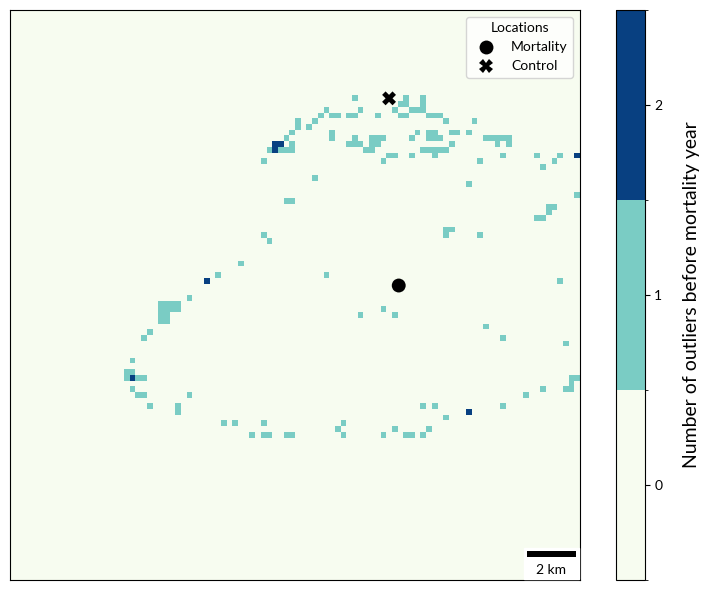

In [59]:
# SUBPLOT: Outliers
fig, ax = plt.subplots(figsize=(7.5, 6))
n_outliers.isel(x = slice(40, 140), y = slice(60, 160)).plot(ax = ax, cmap = 'GnBu', cbar_kwargs={"location": "right", 'pad' : 0.05}, levels = np.arange(0, 4, 1))
#Change colorbar label and put colorbar at the bottom of the plot
ax.set_aspect('equal')
cbar = ax.collections[0].colorbar
cbar.set_label(r'Number of outliers before mortality year', fontsize=14, labelpad = 15)

#Ticks along colorbar: just integers
cbar.set_ticks(ticks = np.arange(.5, 3.5, 1), labels = np.arange(0, 3, 1))

#Add TP and TN points
point_plot = pd.DataFrame({'x' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'x'].values[0],
                    df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'x'].values[0]],
                'y' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'y'].values[0],
                    df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'y'].values[0]],
                'Locations' : ['Mortality', 'Control']})
sns.scatterplot(data = point_plot, x='x', y='y', style = 'Locations', s=100, ax=ax, palette = '', color = 'black', linewidth = 0)

# Add a scale bar
scalebar = ScaleBar(
    dx=1,              # degrees (PlateCarree uses degrees, not meters)
    units='m',
    #dimension='angle', # important for lat/lon maps
    location='lower right',
    length_fraction=0.1  # proportion of axis for scalebar length
)
ax.add_artist(scalebar)
#Remove axis tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
#Remove ticks and axis labels
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
plt.tight_layout()

/tmp/ipykernel_3345006/1207848024.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = point_plot, x='x', y='y', style = 'Locations', s=100, ax=ax, palette = '', color = 'black', linewidth = 0)


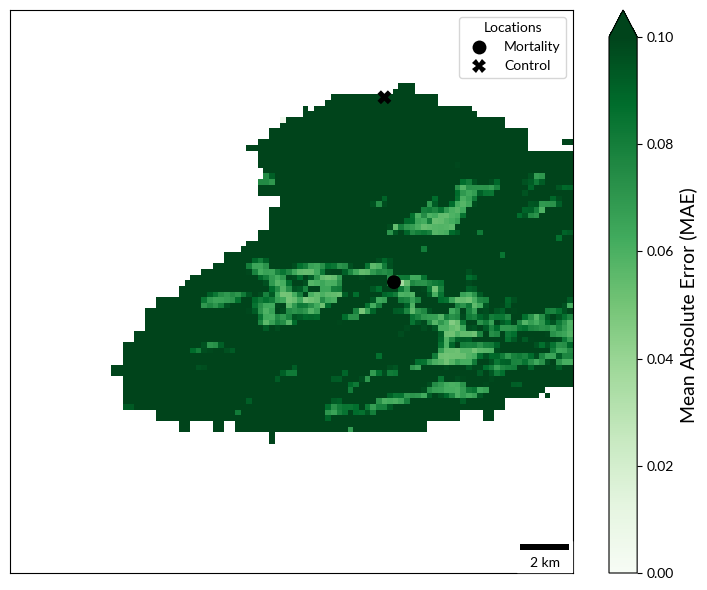

In [60]:
#Plot MAE
fig, ax = plt.subplots(figsize=(7.5, 6))
mae_xr.isel(x = slice(40, 140), y = slice(60, 160)).plot(ax = ax, cmap = 'Greens', vmin = 0, vmax = 0.1, cbar_kwargs={"location": "right", 'pad' : 0.05})
#Change colorbar label and put colorbar at the bottom of the plot
ax.set_aspect('equal')
cbar = ax.collections[0].colorbar
cbar.set_label(r'Mean Absolute Error (MAE)', fontsize=14)

#Add TP and TN points
point_plot = pd.DataFrame({'x' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'x'].values[0],
                    df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'x'].values[0]],
                'y' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'y'].values[0],
                    df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'y'].values[0]],
                'Locations' : ['Mortality', 'Control']})
sns.scatterplot(data = point_plot, x='x', y='y', style = 'Locations', s=100, ax=ax, palette = '', color = 'black', linewidth = 0)

# Add a scale bar
scalebar = ScaleBar(
    dx=1,              # degrees (PlateCarree uses degrees, not meters)
    units='m',
    #dimension='angle', # important for lat/lon maps
    location='lower right',
    length_fraction=0.1  # proportion of axis for scalebar length
)
ax.add_artist(scalebar)
#Remove axis tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
#Remove ticks and axis labels
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
plt.tight_layout()

/tmp/ipykernel_3345006/195378944.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = point_plot, x='x', y='y', style = 'Locations', s=100, ax=ax, palette = '', color = 'black', linewidth = 0)


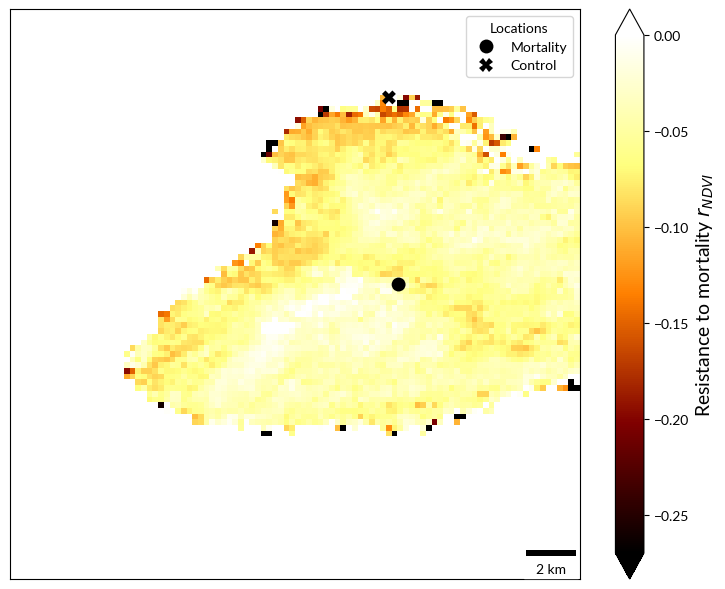

/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [61]:
#SUBPLOT: Resistance
fig, ax = plt.subplots(figsize = (7.5, 6)) #, subplot_kw={'projection': ccrs.PlateCarree()})
df_ndvi_diff.isel(x = slice(40, 140), y = slice(60, 160)).plot(cmap = 'afmhot', vmin = -.27, vmax = 0, ax = ax, 
                    #subplot_kws={'aspect' : 1},   
                cbar_kwargs={"location": "right", 'pad' : 0.05}) #, transform=ccrs.PlateCarree())
#Remove the title
ax.set_title('')
ax.set_aspect('equal')
#Change colorbar label and put colorbar at the bottom of the plot

cbar = ax.collections[0].colorbar
cbar.set_label(r'Resistance to mortality $r_{NDVI}$', fontsize=14)

#Add TP and TN points
point_plot = pd.DataFrame({'x' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'x'].values[0],
                    df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'x'].values[0]],
                'y' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'y'].values[0],
                    df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'y'].values[0]],
                'Locations' : ['Mortality', 'Control']})
sns.scatterplot(data = point_plot, x='x', y='y', style = 'Locations', s=100, ax=ax, palette = '', color = 'black', linewidth = 0)

# Add a scale bar
scalebar = ScaleBar(
    dx=1,              # degrees (PlateCarree uses degrees, not meters)
    units='m',
    #dimension='angle', # important for lat/lon maps
    location='lower right',
    length_fraction=0.1  # proportion of axis for scalebar length
)
ax.add_artist(scalebar)
#Remove axis tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
#Remove ticks and axis labels
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()

/tmp/ipykernel_3345006/1081794165.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = point_plot, x='x', y='y', style = 'Locations', s=100, ax=ax, palette = '', color = 'black', linewidth = 0)


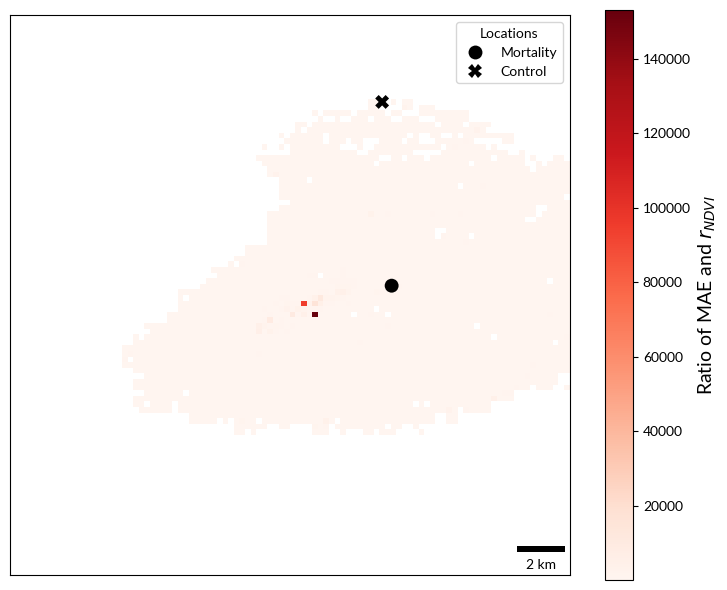

/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [62]:
#Plot ratio xr
fig, ax = plt.subplots(figsize=(7.5, 6))
ratio_masked.isel(x = slice(40, 140), y = slice(60, 160)).plot(cmap = 'Reds',  ax = ax, 
                    #subplot_kws={'aspect' : 1},   
                cbar_kwargs={"location": "right", 'pad' : 0.05}) #, transform=ccrs.PlateCarree())
#Put grey mask on top for all areas that do not have number of breakpoints == 0
#n_outliers_mask.isel(x = slice(40, 140), y = slice(60, 160)).plot(ax = ax, cmap = 'Greys', alpha = .5, add_colorbar = False)
#Remove the title
ax.set_title('')
ax.set_aspect('equal')
#Change colorbar label and put colorbar at the bottom of the plot

cbar = ax.collections[0].colorbar
cbar.set_label(r'Ratio of MAE and $r_{NDVI}$', fontsize=14)

#Add TP and TN points
point_plot = pd.DataFrame({'x' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'x'].values[0],
                    df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'x'].values[0]],
                'y' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'y'].values[0],
                    df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'y'].values[0]],
                'Locations' : ['Mortality', 'Control']})
sns.scatterplot(data = point_plot, x='x', y='y', style = 'Locations', s=100, ax=ax, palette = '', color = 'black', linewidth = 0)

# Add a scale bar
scalebar = ScaleBar(
    dx=1,              # degrees (PlateCarree uses degrees, not meters)
    units='m',
    #dimension='angle', # important for lat/lon maps
    location='lower right',
    length_fraction=0.1  # proportion of axis for scalebar length
)
ax.add_artist(scalebar)
#Remove axis tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
#Remove ticks and axis labels
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()

/tmp/ipykernel_3345006/4185656151.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds = plt.cm.get_cmap('Reds', n_colors - 1)


/tmp/ipykernel_3345006/4185656151.py:49: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=point_plot, x='x', y='y', style='Locations', s=100, ax=ax,


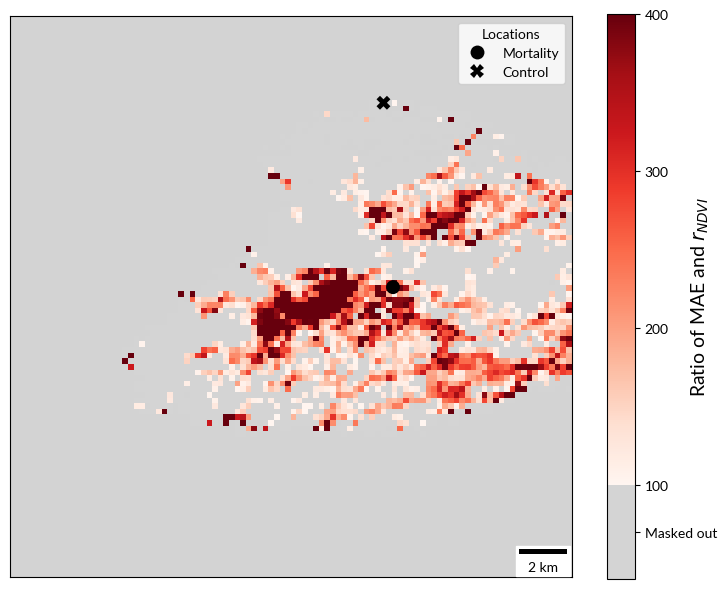

In [63]:
# === Setup color bins and colormap ===
n_colors = 250
vmin, vmax = 100, 400
data_bins = np.linspace(vmin, vmax, n_colors - 1)  # 255 bins for data
bounds = np.concatenate(([-1e6], data_bins))  # First bin: everything <100 → grey

# Create colormap: light grey + Reds
reds = plt.cm.get_cmap('Reds', n_colors - 1)
grey_rgba = np.array([[0.83, 0.83, 0.83, 1.0]])  # RGBA for light grey
colors = np.vstack(list(itertools.chain.from_iterable([[grey_rgba]*50, reds(np.linspace(0, 1, n_colors - 1))])))
cmap = ListedColormap(colors)
cmap.set_bad('lightgrey')
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# === Plot the data ===
fig, ax = plt.subplots(figsize=(7.5, 6))
img = ratio_masked.isel(x=slice(40, 140), y=slice(60, 160)).plot(
    cmap=cmap,
    #norm=norm,
    ax=ax,
    vmin = 100, vmax = 400,
    cbar_kwargs={"location": "right", "pad": 0.05, 'extend': 'neither'}
)
ax.set_aspect('equal')

# === Colorbar custom labels ===
cbar = ax.collections[0].colorbar
cbar.set_label(r'Ratio of MAE and $r_{NDVI}$', fontsize=14, labelpad = -20)

# Define custom ticks: grey label + range
tick_locs = list(itertools.chain.from_iterable([[125], np.arange(150, 400+(400-150)/4, (400-150)/3)]))
tick_labels = list(itertools.chain.from_iterable([['Masked out'], np.arange(100, 500, 100)]))
#cbar.set_ticks(tick_locs)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)

# === Add TP and TN points ===
point_plot = pd.DataFrame({
    'x': [
        df_hammond.loc[df_hammond.entry_id == entry_id, 'x'].values[0],
        df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'x'].values[0]
    ],
    'y': [
        df_hammond.loc[df_hammond.entry_id == entry_id, 'y'].values[0],
        df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'y'].values[0]
    ],
    'Locations': ['Mortality', 'Control']
})
sns.scatterplot(data=point_plot, x='x', y='y', style='Locations', s=100, ax=ax,
                palette='', color='black', linewidth=0)

# === Add scale bar ===
scalebar = ScaleBar(dx=1, units='m', location='lower right', length_fraction=0.1)
ax.add_artist(scalebar)

# === Clean axis ===
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(axis='both', which='both', length=0)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
plt.tight_layout()


/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/tmp/ipykernel_3345006/3929337833.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds = plt.cm.get_cmap('Reds', n_colors - 1)
/tmp/ipykernel_3345006/3929337833.py:143: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=point_plot, x='x', y='y', style='Locations', s=100, ax=ax, palette='', color='black', linewidth=0, legend='full')
/tmp/ipykernel_3345006/3929337833.py:146: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=point_plot, x='x', y='y', style='Locations', s=1

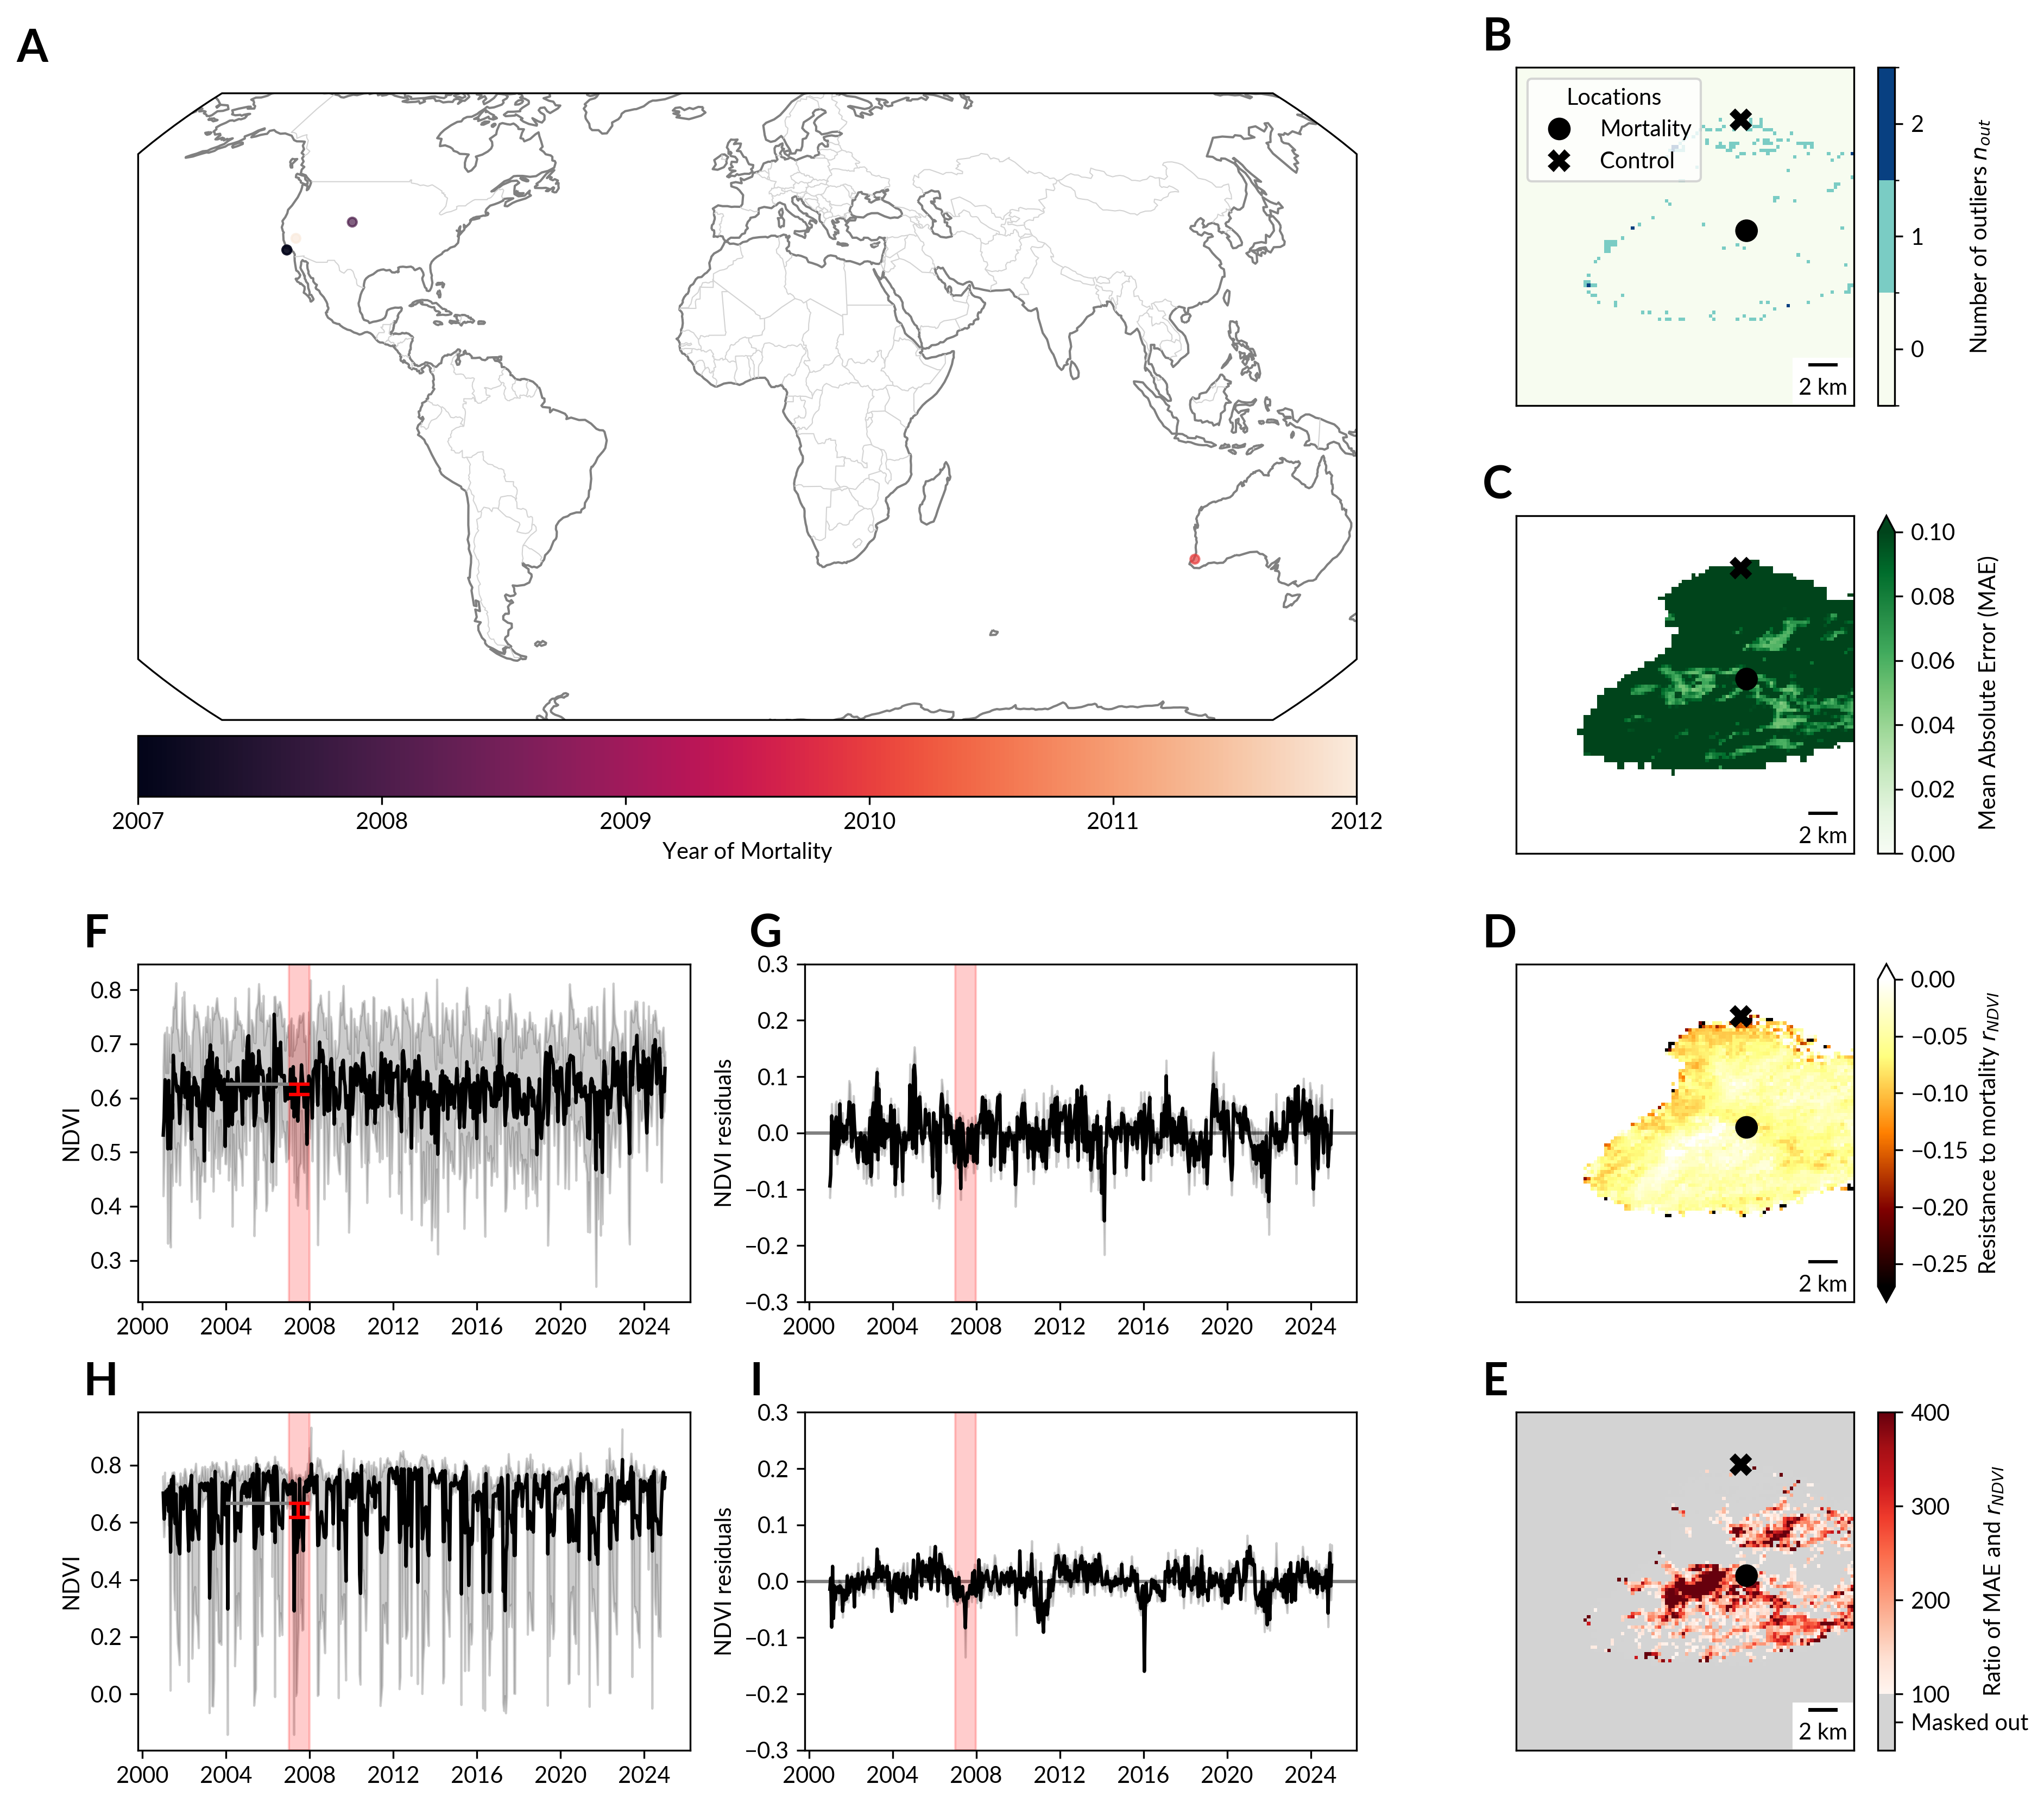

In [64]:
#Complete figure
fig = plt.figure(figsize = (6.3*2, 5.6*2), dpi = 300)
#fig = plt.figure(figsize = (5.6*2, 6.3*2, ), dpi = 300)

# Define the GridSpec: 4 rows × 3 columns, with width ratios
gs = gridspec.GridSpec(nrows=4, ncols=3, width_ratios=[1.5, 1.5, 1.3], height_ratios=[1, 1, 1, 1], figure=fig)

# Plot 1: spans first 2 rows and columns 0 & 1
ax0 = fig.add_subplot(gs[0:2, 0:2], projection=ccrs.Robinson())

#World map: top left
#ax = plt.subplot(3, 4, 1, projection=ccrs.Robinson())
# Load land shapefile (Natural Earth)
path = natural_earth(resolution='110m', category='physical', name='land')
world = gpd.read_file(path)

# Robinson projection
rob_proj = ccrs.Robinson()

# Create GeoDataFrame from your DataFrame (df_hammond assumed preloaded)
gdf_points = gpd.GeoDataFrame(
    df_hammond,
    geometry=gpd.points_from_xy(df_hammond.lon, df_hammond.lat),
    crs="EPSG:4326"
)

# Subset points to be plotted
points_to_plot = gdf_points[gdf_points.true_pos_neg.isin(['true_pos', 'true_pos_adj'])]

# Base map
ax0.set_global()
ax0.set_extent([-150, 150, -70, 70], crs=ccrs.PlateCarree())
ax0.coastlines(color='grey')
ax0.add_feature(cfeature.BORDERS, linewidth=0.5, color='lightgrey')
ax0.add_feature(cfeature.LAND, facecolor='white')

# Plot land outlines
world.to_crs(rob_proj).plot(
    ax=ax0,
    edgecolor='grey',
    facecolor='grey',
    linewidth=0.6,
    zorder=1,
    transform=ccrs.PlateCarree()
)

# Plot points colored by year_disturbance
cmap = 'rocket'
norm = Normalize(vmin=points_to_plot['year_disturbance'].min(), vmax=points_to_plot['year_disturbance'].max())

points_to_plot.plot(
    ax=ax0,
    column='year_disturbance',
    cmap=cmap,
    markersize=15,
    alpha=0.7,
    zorder=2,
    transform=ccrs.PlateCarree()
)

# Add colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required for colorbar without image
cbar = plt.colorbar(sm, ax=ax0, orientation='horizontal', shrink=1, pad=0.02)
cbar.set_label('Year of Mortality')
#cbar.ax.set_aspect(0.05)  # Smaller value = thinner bar


#Add another plot to the right of this one
ax1 = fig.add_subplot(gs[0, 2])
n_outliers.isel(x = slice(40, 140), y = slice(60, 160)).plot(ax = ax1, cmap = 'GnBu', 
                cbar_kwargs={"location": "right", 'pad' : 0.05}, levels = np.arange(0, 4, 1))
#Change colorbar label and put colorbar at the bottom of the plot
cbar = ax1.collections[0].colorbar
cbar.set_label(r'Number of outliers $n_{out}$', labelpad = 20)
#Ticks along colorbar: just integers
cbar.set_ticks(ticks = np.arange(.5, 3.5, 1), labels = np.arange(0, 3, 1))

#Second plot below this: MAE
ax2 = fig.add_subplot(gs[1, 2])
mae_xr.isel(x = slice(40, 140), y = slice(60, 160)).plot(ax = ax2, cmap = 'Greens', vmin = 0, vmax = 0.1, cbar_kwargs={"location": "right", 'pad' : 0.05})
#Change colorbar label and put colorbar at the bottom of the plot
cbar = ax2.collections[0].colorbar
cbar.set_label(r'Mean Absolute Error (MAE)', labelpad = 10)

#Third plot: Resistance to mortality
ax3 = fig.add_subplot(gs[2, 2])
df_ndvi_diff.isel(x = slice(40, 140), y = slice(60, 160)).plot(cmap = 'afmhot', vmin = -.27, vmax = 0, ax = ax3, 
                    #subplot_kws={'aspect' : 1},   
                cbar_kwargs={"location": "right", 'pad' : 0.05}) #, transform=ccrs.PlateCarree())

#Change colorbar label
cbar = ax3.collections[0].colorbar
cbar.set_label(r'Resistance to mortality $r_{NDVI}$')

#Fourth plot: Ratio of MAE and resistance to mortality
ax4 = fig.add_subplot(gs[3, 2])
# === Setup color bins and colormap ===
n_colors = 250
vmin, vmax = 100, 400
data_bins = np.linspace(vmin, vmax, n_colors - 1)  # 255 bins for data
bounds = np.concatenate(([-1e6], data_bins))  # First bin: everything <100 → grey

# Create colormap: light grey + Reds
reds = plt.cm.get_cmap('Reds', n_colors - 1)
grey_rgba = np.array([[0.83, 0.83, 0.83, 1.0]])  # RGBA for light grey
colors = np.vstack(list(itertools.chain.from_iterable([[grey_rgba]*50, reds(np.linspace(0, 1, n_colors - 1))])))
cmap = ListedColormap(colors)
cmap.set_bad('lightgrey')
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# === Plot the data ===
img = ratio_masked.isel(x=slice(40, 140), y=slice(60, 160)).plot(
    cmap=cmap,
    #norm=norm,
    ax=ax4,
    vmin = 100, vmax = 400,
    cbar_kwargs={"location": "right", "pad": 0.05, 'extend': 'neither'}
)

# === Colorbar custom labels ===
cbar = ax4.collections[0].colorbar
cbar.set_label(r'Ratio of MAE and $r_{NDVI}$', labelpad = -20)

# Define custom ticks: grey label + range
tick_locs = list(itertools.chain.from_iterable([[125], np.arange(150, 400+(400-150)/4, (400-150)/3)]))
tick_labels = list(itertools.chain.from_iterable([['Masked out'], np.arange(100, 500, 100)]))
#cbar.set_ticks(tick_locs)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)

#Add the TP and TN points and other layouting things for those maps
for n, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.set_aspect('equal')
    #Add TP and TN points
    point_plot = pd.DataFrame({'x' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'x'].values[0],
                        df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'x'].values[0]],
                    'y' : [df_hammond.loc[df_hammond.entry_id == entry_id, 'y'].values[0],
                        df_points.loc[df_points.true_pos_neg == 'true_neg_ratio', 'y'].values[0]],
                    'Locations' : ['Mortality', 'Control']})
    #Show legend only for n = 0
    if n == 0:
        sns.scatterplot(data=point_plot, x='x', y='y', style='Locations', s=100, ax=ax, palette='', color='black', linewidth=0, legend='full')
    else:
        #No legend for other plots
        sns.scatterplot(data=point_plot, x='x', y='y', style='Locations', s=100, ax=ax, palette='', color='black', linewidth=0, legend=False)


    # Add a scale bar
    scalebar = ScaleBar(
        dx=1,              # degrees (PlateCarree uses degrees, not meters)
        units='m',
        #dimension='angle', # important for lat/lon maps
        location='lower right',
        length_fraction=0.1  # proportion of axis for scalebar length
    )
    ax.add_artist(scalebar)
    #Remove axis tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #Remove ticks and axis labels
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')


#Time series plots at the bottom
#Fifth plot: Time series of NDVI for the mortality point
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])
ax7 = fig.add_subplot(gs[3, 0])
ax8 = fig.add_subplot(gs[3, 1])

df_ews['time'] = df_ews['cleandate']
#Plot the time series (left positive, right negative)
sns.lineplot(data=df_ts.loc[df_ts.true_pos_neg == 'true_pos'], x='time', y='NDVI', ax=ax5, color='black')
sns.lineplot(data=df_ts.loc[df_ts.true_pos_neg == 'true_neg_ratio'], x='time', y='NDVI', ax=ax7, color='black')
sns.lineplot(data=df_ews.loc[((df_ews.true_pos_neg == 'true_pos') & (df_ews.VI == 'NDVI'))], x='time', y='VI_dtl_stl', ax=ax6, color='black')
sns.lineplot(data=df_ews.loc[((df_ews.true_pos_neg == 'true_neg_ratio') & (df_ews.VI == 'NDVI'))], x='time', y='VI_dtl_stl', ax=ax8, color='black')

#For all the plots, highlight the year of collapse
collapse_year = df_hammond.loc[df_hammond.entry_id == entry_id, 'year_disturbance'].values[0]
for a in [ax5, ax6, ax7, ax8]:
    #Make a highlighted rectangle with the dates (x-axis is date axis)
    a.axvspan(pd.to_datetime(f'{collapse_year}-01-01'), pd.to_datetime(f'{collapse_year}-12-31'), color='red', alpha=0.2)
    a.set_xlabel('')
#Make thin dashed horizontal lines at y = 0 for residuals
ax6.axhline(0, color='grey',  zorder = -1)
ax8.axhline(0, color='grey',zorder = -1)
#Set y-axis limtis for residuals
ax6.set_ylim(-.3, .3)
ax8.set_ylim(-.3, .3)
#y-axis labels
ax6.set_ylabel('NDVI residuals')
ax8.set_ylabel('NDVI residuals')

#For NDVI plots: add mean in 3 years before collapse and add scale for resistance
pre_mean_tp  = df_ts.loc[((df_ts.true_pos_neg == 'true_pos') & (df_ts.time < pd.to_datetime(f'{collapse_year}-01-01')) & (df_ts.time >= pd.to_datetime(f'{int(collapse_year)-3}-01-01')))].NDVI.mean()
mort_mean_tp = df_ts.loc[((df_ts.true_pos_neg == 'true_pos') & (df_ts.time >= pd.to_datetime(f'{collapse_year}-01-01')) & (df_ts.time <= f'{collapse_year}-12-31'))].NDVI.mean()
#Add this to plot for just the three yers before collapse
ax5.hlines(pre_mean_tp, xmin = pd.to_datetime(f'{int(collapse_year)-3}-01-01'), xmax = pd.to_datetime(f'{collapse_year}-01-01'), 
                    color='grey',  label = 'Mean NDVI pre-collapse')
ax5.hlines(mort_mean_tp, xmin = pd.to_datetime(f'{collapse_year}-01-01'), xmax = pd.to_datetime(f'{collapse_year}-12-31'),
                    color='red',  label = 'Mean NDVI post-collapse')
ax5.hlines(pre_mean_tp,  xmin = pd.to_datetime(f'{collapse_year}-01-01'), xmax = pd.to_datetime(f'{collapse_year}-12-31'),
                    color='red')
#Make vertical line connecting those two
ax5.vlines(pd.to_datetime(f'{collapse_year}-06-15'), ymin = pre_mean_tp, ymax = mort_mean_tp, color='red')

#Do the same for the true negative
pre_mean_tn  = df_ts.loc[((df_ts.true_pos_neg == 'true_neg_ratio') & (df_ts.time < pd.to_datetime(f'{collapse_year}-01-01')) & (df_ts.time >= pd.to_datetime(f'{int(collapse_year)-3}-01-01')))].NDVI.mean()
mort_mean_tn = df_ts.loc[((df_ts.true_pos_neg == 'true_neg_ratio') & (df_ts.time >= pd.to_datetime(f'{collapse_year}-01-01')) & (df_ts.time <= f'{collapse_year}-12-31'))].NDVI.mean()
ax7.hlines(pre_mean_tn, xmin = pd.to_datetime(f'{int(collapse_year)-3}-01-01'), xmax = pd.to_datetime(f'{collapse_year}-01-01'), 
                    color='grey',  label = 'Mean NDVI pre-collapse')
ax7.hlines(mort_mean_tn, xmin = pd.to_datetime(f'{collapse_year}-01-01'), xmax = pd.to_datetime(f'{collapse_year}-12-31'),
                    color='red',  label = 'Mean NDVI post-collapse')
ax7.hlines(pre_mean_tn,  xmin = pd.to_datetime(f'{collapse_year}-01-01'), xmax = pd.to_datetime(f'{collapse_year}-12-31'),
                    color='red')
#Make vertical line connecting those two
ax7.vlines(pd.to_datetime(f'{collapse_year}-06-15'), ymin = pre_mean_tn, ymax = mort_mean_tn, color='red')

#Annotate subplots
for n, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8], start=1):
    ax.text(-0.1, 1.05, string.ascii_uppercase[n-1], transform = ax.transAxes, size = 20, weight = 'bold')

plt.tight_layout()
#Export in high quality
plt.savefig('./plots/01_figure_methods', dpi = 500, bbox_inches = 'tight')

## Section 4.2: Evidence for mortality events and control point identification

In [65]:
# Load paired dataset of true positives and true negatives
df_paired = pd.read_feather('./data/intermediary/MOD13Q1_extracted_timeseries/all_points.feather')
#Keep only true_pos and true_neg_ratio
df_paired = df_paired.loc[df_paired.true_pos_neg.isin(['true_pos', 'true_neg_ratio'])].reset_index(drop = True)
#Get number of complete pairs
print('Complete pairs:', sum(df_paired.groupby('paired_id').size() == 2))
paired_ids_complete = df_paired.groupby('paired_id').size() == 2
paired_ids_complete = paired_ids_complete[paired_ids_complete].index.tolist()
entry_ids_complete = df_paired.loc[df_paired.paired_id.isin(paired_ids_complete), 'entry_id'].unique().tolist()

Complete pairs: 5


In [66]:
# Group by entry_id and compute distance between the two points
def compute_distance(group):
    if len(group) != 2:
        return np.nan  # or raise an error if this is unexpected
    dx = group.iloc[1]['x'] - group.iloc[0]['x']
    dy = group.iloc[1]['y'] - group.iloc[0]['y']
    return np.sqrt(dx**2 + dy**2)

# Apply the function to each group
distances = df_paired.groupby('entry_id').apply(compute_distance, include_groups = False).reset_index(name='distance')
print('Distances between true positives and controls (m):')
print('mean distance (m):', distances.distance.mean(), '\n'
        'std distance (m):', distances.distance.std(), '\n'
        'median distance (m):', distances.distance.median(), '\n'
        '5th percentile distance (m):', distances.distance.quantile(.05), '\n'
        '95th percentile distance (m):', distances.distance.quantile(.95))

Distances between true positives and controls (m):
mean distance (m): 5852.660285817279 
std distance (m): 1917.2533956154323 
median distance (m): 6164.697101277751 
5th percentile distance (m): 3782.7714350376446 
95th percentile distance (m): 7719.0697064873975


In [68]:
#Evaluate drop in NDVI at true positives vs controls
df_resistance = pd.read_feather(find_newest_file('./data/final/MOD13Q1_ews_resistance_recovery', 'all_resistance_df.feather')).drop_duplicates()

In [69]:
#Evaluate differences in recovery rate
df_recovery = pd.read_feather(find_newest_file('./data/final/MOD13Q1_ews_resistance_recovery', 'all_exp_df.feather')).drop_duplicates()

In [70]:
#Also join the two dataframes
df_res_exp = df_resistance.merge(df_recovery, on = ['entry_id', 'true_pos_neg',  'VI'])

In [150]:
#For this, keep only complete pairs
data = df_res_exp.loc[df_res_exp.true_pos_neg.isin(['true_pos', 'true_neg_ratio'])].copy()
print(data.shape)
#Keep only the ones that have two entries
dsize = data.groupby(['entry_id', 'VI']).size().reset_index(name='count_vals')
data = pd.merge(data, dsize, how = 'left')
data = data.loc[data.count_vals == 2].copy().drop(columns = ['count_vals'])
data.loc[:, 'true_pos_neg'] = data.true_pos_neg.map({'true_pos': 'Mortality', 'true_neg_ratio': 'Control'})
print(data.shape)
#All pairs are complete!

(30, 14)
(30, 14)


In [151]:
#Get fraction of values that show negative resistance for each VI and for TP/TN
print('Fraction of points with negative resistance:')
for vi in data.VI.unique():
    print(vi)
    print('Mortality:',data.loc[((data.true_pos_neg == 'Mortality') & (data.resistance < 0) & (data.VI == vi))].shape[0] / data.loc[((data.VI == vi) & (data.true_pos_neg == 'Mortality'))].shape[0])
    print('Control:', data.loc[((data.true_pos_neg == 'Control') & (data.resistance < 0) & (data.VI == vi))].shape[0] / data.loc[((data.VI == vi) & (data.true_pos_neg == 'Control'))].shape[0])
    #t-test between mortality and control resistance
    dsub = data.loc[data.VI == vi]
    #Drop nans
    dsub = dsub.dropna(subset=['resistance'])
    t_sta, p_val = stats.ttest_ind(dsub.loc[dsub.true_pos_neg == 'Mortality'].resistance, 
                                      dsub.loc[dsub.true_pos_neg == 'Control'].resistance)
    print('T-statistic:', t_sta, 'P-value:', p_val)
#Also show overview of all VIs
print('All VIs:')
print('Mortality:',data.loc[(data.true_pos_neg == 'Mortality') & (data.resistance < 0)].shape[0] / data.loc[data.true_pos_neg == 'Mortality'].shape[0])
print('Control:', data.loc[(data.true_pos_neg == 'Control') & (data.resistance < 0)].shape[0] / data.loc[data.true_pos_neg == 'Control'].shape[0])

Fraction of points with negative resistance:
EVI
Mortality: 1.0
Control: 0.4
T-statistic: -4.366610590927061 P-value: 0.0047364035172527035
NDVI
Mortality: 0.8
Control: 0.4
T-statistic: -1.676212621542716 P-value: 0.14471234018360532
kNDVI
Mortality: 0.8
Control: 0.4
T-statistic: -2.1155169561652984 P-value: 0.07876990375691127
All VIs:
Mortality: 0.8666666666666667
Control: 0.4


In [152]:
#Mean drop in VI at TP
print('Mean drop in VI at TP:')
data.loc[data.true_pos_neg == 'Mortality'].groupby('VI').resistance_rel.mean()

Mean drop in VI at TP:


VI
EVI     -0.09315
NDVI    -0.03168
kNDVI   -0.05599
Name: resistance_rel, dtype: float64

In [153]:
#Maximum drop in VI at TP (ie time point of lowest productivity during mortality year)
print('Maximum drop in VI at TP:')
data.loc[data.true_pos_neg == 'Mortality'].groupby('VI').resistance_max_rel.mean()

Maximum drop in VI at TP:


VI
EVI     -0.332054
NDVI    -0.182952
kNDVI   -0.310212
Name: resistance_max_rel, dtype: float64

In [154]:
#Maximum drop in VI at TP in standrd deviation units
print('Maximum drop in VI at TP in standrd deviation units:')
data.loc[data.true_pos_neg == 'Mortality'].groupby('VI').resistance_sd_ratio.mean()

Maximum drop in VI at TP in standrd deviation units:


VI
EVI     -1.979793
NDVI    -1.964527
kNDVI   -1.903337
Name: resistance_sd_ratio, dtype: float64

In [156]:
#Compute paired ratios of resistance and recovery rate

#Pivot true_pos_neg to wide for resistance and r
df_stats = df_res_exp.loc[df_res_exp.true_pos_neg.isin(['true_pos', 'true_neg_ratio'])].pivot(index = ['entry_id', 'VI'],columns = 'true_pos_neg', values = ['resistance', 'r']).reset_index()
#Adjust column headers to be just one row
df_stats.columns = ['_'.join(col).strip() for col in df_stats.columns.values]
#Drop trailing '_' in columns
df_stats.columns = df_stats.columns.str.rstrip('_')
#Compute resistance ratio and r ratio
df_stats['resistance_ratio'] = df_stats['resistance_true_neg_ratio']/df_stats['resistance_true_pos'] - 1
df_stats['r_ratio'] = df_stats['r_true_neg_ratio']/df_stats['r_true_pos'] - 1
#df_stats = df_stats.drop_duplicates(subset = ['VI', 'resistance_true_neg_ratio', 'resistance_true_pos', 'r_true_neg_ratio', 'r_true_pos', 'resistance_ratio', 'r_ratio'])
#df_stats.sort_values(by = 'resistance_true_pos', ascending = True).head(20)

In [157]:
#Get stats for resistance
print('resistance diff ratio:', df_stats.resistance_ratio.mean(), df_stats.resistance_ratio.quantile(.05), df_stats.resistance_ratio.quantile(.95))
#Significance testing with paired ttest
df_subset_ttest_1 = df_stats[['resistance_true_neg_ratio', 'resistance_true_pos']].dropna()
true_neg_vals = df_subset_ttest_1.resistance_true_neg_ratio
true_pos_vals = df_subset_ttest_1.resistance_true_pos
t_stat, p_val = ttest_rel(true_neg_vals, true_pos_vals)
print('Paired t-test statistic:', t_stat)
print('Paired t-test p-value:', p_val)

resistance diff ratio: -1.9974207068107386 -5.8133544829302 -0.7390724507865758
Paired t-test statistic: 2.7985107245667598
Paired t-test p-value: 0.02325116243681378


In [158]:
#Get recovery rate diff ratio
print('recovery rate diff ratio:', df_stats.r_ratio.mean(), df_stats.r_ratio.quantile(.05), df_stats.r_ratio.quantile(.95))
#Significance testing for recovery rate with paired ttest
df_subset_ttest_2 = df_stats[['r_true_neg_ratio', 'r_true_pos']].dropna()
true_neg_vals = df_subset_ttest_2.r_true_neg_ratio
true_pos_vals = df_subset_ttest_2.r_true_pos
t_stat, p_val = ttest_rel(true_neg_vals, true_pos_vals)
print('Paired t-test statistic:', t_stat)
print('Paired t-test p-value:', p_val)

recovery rate diff ratio: 2.6647326842215215 -0.8674660835748716 14.87487869146271
Paired t-test statistic: 0.5496096585246409
Paired t-test p-value: 0.5975911661192972


## Section 4.3: EWS performance

In [143]:
#Load the summarized kt_trend values
df_kt = pd.read_feather(find_newest_file('./data/final/MOD13Q1_ews_resistance_recovery', 'all_ews_df.feather')).dropna().drop_duplicates()
#Replace any true_pos_adj with true_pos
df_kt.loc[df_kt.true_pos_neg == 'true_pos_adj', 'true_pos_neg'] = 'true_pos'
#Keep only true_pos and true_neg_ratio
df_kt = df_kt.loc[df_kt.true_pos_neg.isin(['true_pos', 'true_neg_ratio'])].reset_index(drop = True)
#Remove the full setup
df_kt = df_kt.loc[~df_kt.Setup.isin(['full_setup'])].reset_index(drop = True)

#For each setup, keep only complete pairs
ews_counts = df_kt.dropna(subset = 'kt_stat').groupby(['paired_id', 'VI','rolling_window', 'Setup', 'EWS']).size().reset_index(name = 'counts')
#Add this to the main table
df_kt = df_kt.merge(ews_counts, on=['paired_id', 'VI', 'rolling_window', 'Setup', 'EWS'], how='left')
#Keep only complete ones
df_kt = df_kt.loc[df_kt.counts == 2].copy().drop(columns = ['counts']).reset_index(drop = True)
#Add column with kt_trend
#Donut plots for all EWS (fraction of points that have significant trends (positive for AC1 and var)
df_kt['kt_trend'] = 'Not significant'
df_kt.loc[((df_kt.kt_stat > 0) & (df_kt.kt_pval < 0.05)), 'kt_trend'] = 'Significant positive trend'
df_kt.loc[((df_kt.kt_stat < 0) & (df_kt.kt_pval < 0.05)), 'kt_trend'] = 'Significant negative trend'

In [144]:
#Get summary of fraction of significant trends for each EWS, and VI
df_summary = df_kt.groupby(['VI', 'EWS', 'true_pos_neg', 'kt_trend', 'Setup']).size().reset_index(name = 'counts')
#Get total counts for each group to compute fractions
total_counts = df_summary.groupby(['VI', 'EWS', 'true_pos_neg'])['counts'].transform('sum')
df_summary['fraction'] = df_summary['counts'] / total_counts
#Summarize one step higher per VI, EWS, true_pos_neg and get mean and std of fractions
df_summary_mean = df_summary.groupby(['VI', 'EWS', 'true_pos_neg', 'kt_trend']).agg(
    mean_fraction=('fraction', 'mean'),
    std_fraction=('fraction', 'std')
).reset_index()

#Figures reported in paper
print('Fraction of setups with significant positive trends in EWS for NDVI at true positives:')
df_summary_mean.loc[((df_summary_mean.VI == 'NDVI') & (df_summary_mean.kt_trend.isin(['Significant positive trend', 'Significant negative trend'])) & (df_summary_mean.true_pos_neg == 'true_pos'))]

Fraction of setups with significant positive trends in EWS for NDVI at true positives:


VI       EWS true_pos_neg                    kt_trend  mean_fraction  \
33  NDVI   ews_ac1     true_pos  Significant negative trend       0.054545   
34  NDVI   ews_ac1     true_pos  Significant positive trend       0.088312   
39  NDVI    ews_fd     true_pos  Significant negative trend       0.080745   
40  NDVI    ews_fd     true_pos  Significant positive trend       0.039130   
45  NDVI  ews_kurt     true_pos  Significant negative trend       0.093750   
46  NDVI  ews_kurt     true_pos  Significant positive trend       0.025000   
51  NDVI  ews_skew     true_pos  Significant negative trend       0.073661   
52  NDVI  ews_skew     true_pos  Significant positive trend       0.053571   
57  NDVI   ews_var     true_pos  Significant negative trend       0.078788   
58  NDVI   ews_var     true_pos  Significant positive trend       0.046753   

    std_fraction  
33      0.000000  
34      0.033899  
39      0.037051  
40      0.028344  
45      0.038273  
46      0.013975  
51      0.030876  
52      0.021832  
57      0.029691  
58      0.055404

In [145]:
#Mann-Whitney U test to compare kt_stat values between true positives and true negatives for each VI, EWS, Setup & rolling window
print('Mann-Whitney U test results comparing kt_stat between true positives and true negatives...')

#Loop through all EWS, VI, Setups and rolling windows and compute the t-test of difference between true_pos and true_neg_ratio
#Create empty list and append results to it
ews_out_list = []

for EWS in tqdm(df_kt.EWS.unique(), desc = 'Looping through all setups...', total = len(df_kt.EWS.unique())):
    for VI in df_kt.VI.unique():
        for Setup in df_kt.Setup.unique():
            for rolling_window in df_kt.rolling_window.unique():
                #Subset the data
                df_subset = df_kt.loc[
                    (df_kt.EWS == EWS) &
                    (df_kt.VI == VI) &
                    (df_kt.Setup == Setup) &
                    (df_kt.rolling_window == rolling_window) & 
                    (df_kt.true_pos_neg.isin(['true_pos', 'true_neg_ratio']))
                ]
                #Delete nans
                df_subset = df_subset.dropna(subset=['kt_stat', 'true_pos_neg'])
                #Keep only those with statistically significant trends
                df_subset = df_subset.loc[df_subset.kt_pval < 0.05].reset_index(drop=True)
                #Keep only complete cases (ie entry_id values where both true_pos and true_neg_ratio are present)
                df_subset = df_subset.groupby('entry_id').filter(lambda x: len(x) == 2)
                
                #Perform t-test
                if len(df_subset) > 0:

                    group1 = df_subset.loc[df_subset.true_pos_neg == 'true_pos', 'kt_stat']
                    group2 = df_subset.loc[df_subset.true_pos_neg == 'true_neg_ratio', 'kt_stat']
                    #Also append the mean difference
                    mean_diff = group2.mean() - group1.mean()
                    #Also add number of points in each group
                    n_group1 = len(group1)
                    n_group2 = len(group2)
                    
                    if len(group1) > 0 and len(group2) > 0:
                        t_stat, p_val = stats.mannwhitneyu(group1, group2)
                        #Append the results as a dict to list
                        ews_out_list.append({
                            'EWS': EWS,
                            'VI': VI,
                            'Setup': Setup,
                            'rolling_window': rolling_window,
                            't_statistic': t_stat,
                            'p_value': p_val,
                            'mean_diff': mean_diff,
                            'n_group1': n_group1,
                            'n_group2': n_group2
                        })

#Make this list into a dataframe
ews_out_df = pd.DataFrame(ews_out_list)
#Check if any p-values are < 0.05
significant_results = ews_out_df[ews_out_df['p_value'] < 0.05]
#Print the significant results
print('Setups with significant differences in kt_stat between true positives and true negatives (p < 0.05):')
print(significant_results)
                        

Mann-Whitney U test results comparing kt_stat between true positives and true negatives...


Looping through all setups...: 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

Setups with significant differences in kt_stat between true positives and true negatives (p < 0.05):
Empty DataFrame
Columns: [EWS, VI, Setup, rolling_window, t_statistic, p_value, mean_diff, n_group1, n_group2]
Index: []


### Figure 4: EWS overview

/tmp/ipykernel_3345006/1595791362.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mortality', 'Control'])
/tmp/ipykernel_3345006/1595791362.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mortality', 'Control'])
/tmp/ipykernel_3345006/1595791362.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mortality', 'Control'])
/tmp/ipykernel_3345006/1595791362.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mortality', 'Control'])
/tmp/ipykernel_3345006/1595791362.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_

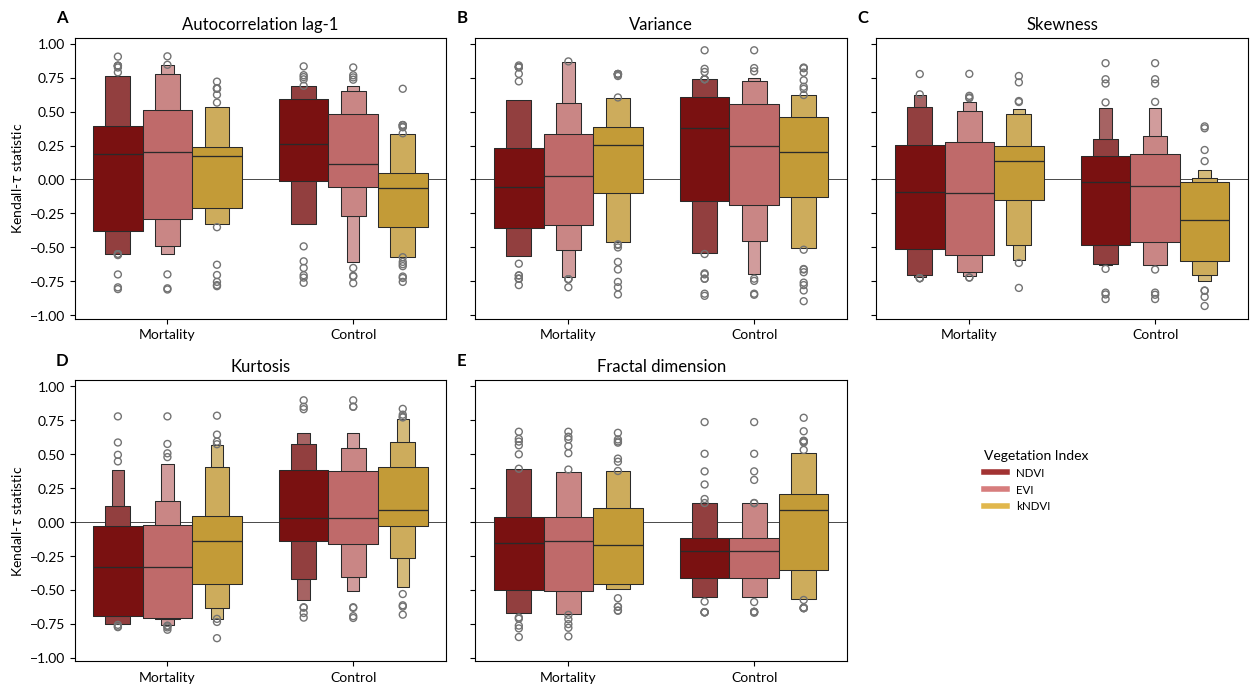

In [ ]:
#Plot the raw kt trend values

# Create the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(6.3*2, 7), sharex=False, sharey=True)

titles = ['Autocorrelation lag-1', 'Variance', 'Skewness', 'Kurtosis', 'Fractal dimension']
colors = ['darkred', 'indianred', 'goldenrod']
labels = ['NDVI', 'EVI', 'kNDVI']
#Make color palette from this

# Compute dodge offsets
x_order = ['true_pos', 'true_neg_ratio']
hue_order = labels

x_map = {k: i for i, k in enumerate(x_order)}
hue_map = {k: i for i, k in enumerate(hue_order)}

n_hues = len(hue_order)
width = 0.8
dodge_amount = width / n_hues


#Create colormap for pval_sig with black for significant and grey for not significant
cmap = sns.color_palette(['lightgrey', 'black'])

# Map to numeric x positions
x_vals = df_kt['true_pos_neg'].map(x_map).to_numpy()
hue_vals = df_kt['VI'].map(hue_map).to_numpy()
x_offsets = (hue_vals - (n_hues - 1) / 2) * dodge_amount
x_scatter = x_vals + x_offsets
df_kt['xscatter'] = x_scatter

#Make new color list that is just dark
labels = ['A', 'B', 'C', 'D', 'E']
axs = axs.flatten()


for i, (ews, label, title) in enumerate(zip(
        ['ews_ac1', 'ews_var', 'ews_skew', 'ews_kurt', 'ews_fd'], labels, titles)):
    
    ax = axs[i]
    leg_bool = (i == 0)
    
    sns.boxenplot(
        data=df_kt.loc[((df_kt.EWS == ews) & (df_kt.true_pos_neg.isin(['true_pos', 'true_neg_ratio'])))],
        x='true_pos_neg', y='kt_stat', hue='VI',
        ax=ax, palette=colors, legend=leg_bool, #inner = None, dodge = True, alpha = .8
    )

    # Add subplot label (A–E)
    ax.text(-0.05, 1.1, label, transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel(r'Kendall-$\tau$ statistic')
    ax.set_xticklabels(['Mortality', 'Control'])
    ax.axhline(0, color = 'black', linewidth = .5, zorder = -1)
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Turn off the unused sixth subplot
axs[5].axis('off')

#Make manual legend, one for the key colors and then one for the darkness based on grey
# Create a custom legend
handles = []
for color in colors:
    handles.append(plt.Line2D([0], [0], color=color, lw=4, label=color, alpha = .8))
# Add the legend to the figure
fig.legend(
    handles, ['NDVI', 'EVI', 'kNDVI'],
    loc='upper left',
    bbox_to_anchor=(.77, .37),  # Adjust as needed
    title='Vegetation Index',
    fontsize='small', frameon = False, alignment = 'left'
)

# Remove internal subplot legend
axs[0].get_legend().remove()
plt.tight_layout()

#Save figure
plt.savefig('./plots/02_figure_results.png', dpi=700, bbox_inches='tight', transparent=True)



## Section 4.4: Driver analysis

In [84]:
#Evaluate driver model performance

#Take newest performance file
df_performance = pd.read_feather(find_newest_file('./data/final/explainer_model_output/', 'performance.feather'))

#Look at performances
print('Model performance summary:')
#Summarize by mean and std of each numeric column
print(df_performance.describe().T[['mean', 'std']])

Model performance summary:
                mean       std
r2_train    0.999827  0.000099
rmse_train  0.005596  0.001444
r2_test     0.458393  0.260740
rmse_test   0.305869  0.058162


In [85]:
#Look at overview of permutation importance
df_importance = pd.read_feather(find_newest_file('./data/final/explainer_model_output/', 'importance.feather'))

#Look at overview of permutation importance
print('Permutation importance summary:')
df_importance.groupby(['feature']).permutation_importance_mean.agg(['mean', 'std']).reset_index().sort_values(by='mean', ascending=False)

Permutation importance summary:


feature      mean       std
1                 Setup  0.646195  0.289271
7        rolling_window  0.476872  0.256985
3            aet_year_1  0.342037  0.297223
6   resistance_sd_ratio  0.322459  0.331131
5                     r  0.109195  0.151304
4            def_year_1  0.080403  0.187053
8           soil_year_1  0.000000  0.000000
0           PDSI_year_1  0.000000  0.000000
10          tmax_year_1  0.000000  0.000000
9           srad_year_1  0.000000  0.000000
11           vpd_year_1  0.000000  0.000000
2               abs_lat -0.018385  0.070082

In [86]:
#Pivot importance dataframe for plotting
importance_df_long = df_importance.melt(id_vars=['VI', 'EWS', 'feature'], 
                                     value_vars=['importance', 'permutation_importance_mean'],
                                     var_name='importance_type', value_name='importance_value')
#Add driver category
driver_categories_cont = {
    'rolling_window': 'Method',
    'Setup': 'Method',
    'aet_year_1': 'Climate',
    'def_year_1': 'Climate',    
    'soil_year_1': 'Climate',
    'srad_year_1': 'Climate',
    'tmax_year_1': 'Climate',
    'vpd_year_1': 'Climate',
    'PDSI_year_1': 'Climate',
    'r': 'Event',
    'resistance_sd_ratio': 'Event',
    'abs_lat': 'Event',
    'true_pos_neg': 'Type'
}
importance_df_long['driver_category'] = importance_df_long['feature'].map(driver_categories_cont)
print(importance_df_long.head())
#Make proper names
ews_labels = ['Autocorrelation\nlag-1', 'Variance', 'Skewness', 'Kurtosis', 'Fractal\nDimension']
driver_orig = ['rolling_window', 'Setup', 'aet_year_1', 'def_year_1',
       'soil_year_1', 'srad_year_1', 'tmax_year_1', 'vpd_year_1',
       'PDSI_year_1', 'r', 'resistance_sd_ratio', 'abs_lat']
driver_labels = ['Rolling window length', 'Time before event', 'Actual evapotranspiration', 'Climate water deficit', 'Soil moisture',
    'Downward surface shortwave radiation', 'Maximum monthly temperature', 'Vapor pressure deficit', 'Palmer Drought Severity Index', 'Recovery rate',  r'Resistance ($\sigma$)', r'Absolute Latitude']
#Make this into dict
driver_map = dict(zip(driver_orig, driver_labels))
#Map feature names to features
importance_df_long['feature'] = importance_df_long['feature'].map(driver_map)
#Also map proper EWS names
ews_map = dict(zip(importance_df_long['EWS'].unique(), ews_labels))
importance_df_long['EWS'] = importance_df_long['EWS'].map(ews_map)
print(importance_df_long.head())

     VI      EWS         feature importance_type  importance_value  \
0  NDVI  ews_ac1  rolling_window      importance          0.089278   
1  NDVI  ews_ac1           Setup      importance          0.168995   
2  NDVI  ews_ac1      aet_year_1      importance          0.147538   
3  NDVI  ews_ac1      def_year_1      importance          0.034373   
4  NDVI  ews_ac1     soil_year_1      importance          0.000000   

  driver_category  
0          Method  
1          Method  
2         Climate  
3         Climate  
4         Climate  
     VI                     EWS                    feature importance_type  \
0  NDVI  Autocorrelation\nlag-1      Rolling window length      importance   
1  NDVI  Autocorrelation\nlag-1          Time before event      importance   
2  NDVI  Autocorrelation\nlag-1  Actual evapotranspiration      importance   
3  NDVI  Autocorrelation\nlag-1      Climate water deficit      importance   
4  NDVI  Autocorrelation\nlag-1              Soil moisture      impor

        VI                     EWS                feature  \
0     NDVI  Autocorrelation\nlag-1  Rolling window length   
1     NDVI  Autocorrelation\nlag-1      Time before event   
60   kNDVI  Autocorrelation\nlag-1  Rolling window length   
61   kNDVI  Autocorrelation\nlag-1      Time before event   
120    EVI  Autocorrelation\nlag-1  Rolling window length   
121    EVI  Autocorrelation\nlag-1      Time before event   
180   NDVI  Autocorrelation\nlag-1  Rolling window length   
181   NDVI  Autocorrelation\nlag-1      Time before event   
240  kNDVI  Autocorrelation\nlag-1  Rolling window length   
241  kNDVI  Autocorrelation\nlag-1      Time before event   
300    EVI  Autocorrelation\nlag-1  Rolling window length   
301    EVI  Autocorrelation\nlag-1      Time before event   

                 importance_type  importance_value driver_category  
0                     importance          0.089278          Method  
1                     importance          0.168995          Method  

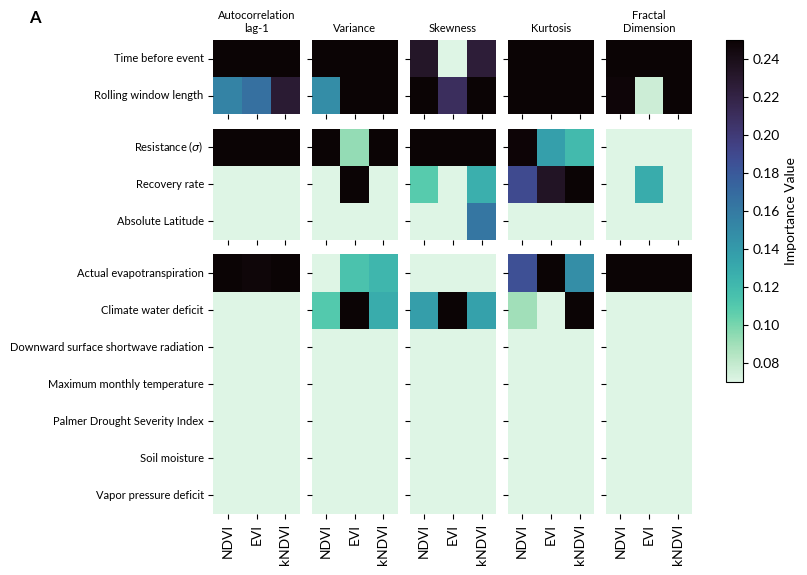

In [139]:
#Make importance heatmap plot
imp_overview = importance_df_long.groupby(['feature']).agg({'importance_value': 'mean'}).reset_index()
feature_order = imp_overview.sort_values(by='importance_value', ascending=False).feature.tolist()
fig, axs = plt.subplots(3 ,5, figsize=(6.3*4/3, 6), sharex=True, sharey='row', height_ratios = [2, 3, 7])
cmap = 'mako_r'
cmap_vmin = 0.07
cmap_vmax = 0.25
#Loop through all EWS and plot the heatmap
for i, ews in enumerate(importance_df_long.EWS.unique()):
    for j, dc in enumerate(['Method', 'Event', 'Climate']):
        ax = axs[:, i]
        #Subset the data
        importance_subset = importance_df_long.loc[((importance_df_long.EWS == ews) & (importance_df_long.driver_category == dc))]
        print(importance_subset)
        #Make sure the feature is in the right order
        #Make a pivot table
        importance_pivot = importance_subset.pivot_table(index='feature', columns='VI', values='importance_value')
        #Get just the relevant features for order
        feature_order_sub = [f for f in feature_order if f in importance_pivot.index]
        #Sort the features by their mean importance value
        importance_pivot.index = pd.CategoricalIndex(importance_pivot.index, categories=feature_order_sub, ordered=True)
        importance_pivot.sort_index(inplace=True)
        #Sort VI columns
        importance_pivot = importance_pivot.reindex(columns=['NDVI', 'EVI', 'kNDVI'])
        print(importance_pivot)
        #Plot the heatmap
        sns.heatmap(data=importance_pivot, ax=ax[j], annot=False, cmap=cmap, 
                    cbar_kws={'label': 'Importance Value'}, 
                    cbar = False, vmin = cmap_vmin, vmax = cmap_vmax)
        if i == 0:
            #y-tick labels fontsize 8
            ax[j].set_yticklabels(ax[j].get_yticklabels(), fontsize = 8)
        if j == 0:
            ax[j].set_title(ews, fontsize=8)
        else:
            ax[j].set_title('')
        ax[j].set_xlabel('')
        ax[j].set_ylabel('')
        #x-tick labels vertically
        ax[j].set_xticklabels(ax[j].get_xticklabels(), rotation=90)
        

plt.tight_layout()
#Adjust to add more space to the right
plt.subplots_adjust(right=0.83, top = 0.9)
#Add one colorbar to the right
cbar_ax = fig.add_axes([0.87, 0.33, 0.02, 0.57])
norm = plt.Normalize(vmin=cmap_vmin, vmax=cmap_vmax)
pltsm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
pltsm.set_array([])
cbar = fig.colorbar(pltsm, cax=cbar_ax)
cbar.set_label('Importance Value')


#Add subplot label
axs[0, 0].text(-2, 1.3, 'A', transform=axs[0, 0].transAxes, fontsize=12, fontweight='bold', va='center', ha='right')
#Save to file
plt.savefig(os.path.join('./plots/030_importance_heatmap.png'), dpi = 700)

### SHAP analysis

In [88]:
# Load shap explainers and values
with open(find_newest_file('./data/final/explainer_model_output/shap/', 'explainer_list.pkl'), 'rb') as f:
    explainer_list = pickle.load(f) 
with open(find_newest_file('./data/final/explainer_model_output/shap/', 'shap_values_list.pkl'), 'rb') as f:
    shap_values_list = pickle.load(f)
with open(find_newest_file('./data/final/explainer_model_output/shap/', 'X_train_list.pkl'), 'rb') as f:
    X_train_list = pickle.load(f)

In [93]:
#Plotting functions for SHAP
def smooth(x, y, xgrid):
    samples = np.random.choice(len(x), 50, replace=True)
    y_s = y[samples]
    x_s = x[samples]
    y_sm = statsmodels.api.nonparametric.lowess(y_s,x_s, frac=.3, it=5,
                     return_sorted = False)
    # regularly sample it onto the grid
    y_grid = scipy.interpolate.interp1d(x_s, y_sm, 
                                        fill_value='extrapolate')(xgrid)
    return y_grid


def compute_lowess_with_ci_joint(x, y, hue = None, label = '', K = 500, ci = 0, linecolor = 'red', x_range = 0.99, cmap = 'Spectral'):
    
    if hue is None:
        xgrid = np.linspace(x.quantile(1 - x_range),x.quantile(x_range))
        smooths = np.stack([smooth(x, y, xgrid) for k in range(K)]).T
        #Compute stats
        mean = np.nanmean(smooths, axis=1)
        stderr = scipy.stats.sem(smooths, axis=1)
        stderr = np.nanstd(smooths, axis=1, ddof=0)

        #Plot it
        plt.plot(xgrid, mean, color= linecolor, label = label)
        if ci == 0.95:
            plt.fill_between(xgrid, mean-1.96*stderr,
                            mean+1.96*stderr, alpha=0.1, color = linecolor, label = f'{ci*100:.0f}% CI', zorder = -1)
        elif ci == 0.90:
            plt.fill_between(xgrid, mean-1.645*stderr,
                            mean+1.645*stderr, alpha=0.1, label = f'{ci*100:.0f}% CI', zorder = -1)
    else:
        #Loop over hue values
        #Make into one df
        df = pd.DataFrame({'x': x, 'y': y, 'hue': hue}).reset_index(drop=True)
        x = df['x']
        y = df['y']
        hue = df['hue']



        #Create three colors from this cmap
        if type(cmap) == str:
            cols = plt.get_cmap(cmap)(np.linspace(0, 1, len(hue.unique())))
        elif type(cmap) == list:
            cols = cmap
        for n, h in enumerate(hue.unique()):
            col = cols[n]
            x_sub = x.loc[hue == h].reset_index(drop=True)
            y_sub = y.loc[hue == h].reset_index(drop=True)
            xgrid = np.linspace(x_sub.quantile(1 - x_range), x_sub.quantile(x_range))
            smooths = np.stack([smooth(x_sub, y_sub, xgrid) for k in range(K)]).T
            #Compute stats
            mean = np.nanmean(smooths, axis=1)
            stderr = scipy.stats.sem(smooths, axis=1)
            stderr = np.nanstd(smooths, axis=1, ddof=0)

            #Plot all points together in grey 
            plt.scatter(x, y, color='lightgrey', alpha=0.002, s=1, zorder = -2)

            #Plot it
            plt.plot(xgrid, mean, color= col, label = f'{label} {h}', linewidth = 1.5)
            if ci == 0.95:
                plt.fill_between(xgrid, mean-1.96*stderr,
                                mean+1.96*stderr, alpha=0.1, color = col, label = f'{ci*100:.0f}% CI', zorder = -1)
            elif ci == 0.90:
                plt.fill_between(xgrid, mean-1.645*stderr,
                                mean+1.645*stderr, alpha=0.1, label = f'{ci*100:.0f}% CI', zorder = -1, color = col)
            elif ci == 0:
                None
        #Limit the axes to x_range limits
        plt.xlim(x.quantile(1 - x_range), x.quantile(x_range))
        plt.ylim(y.quantile(1-x_range), y.quantile(x_range))


def customJoint(x, y, *args, **kwargs):
    data = kwargs.get('data', None)
    hue = kwargs.get('hue', None)
    cmap = kwargs.get('cmap', None)

    if data is not None and hue is not None:
        print('hue is defined')
        hue = data[hue]
        compute_lowess_with_ci_joint(x, y, hue = hue, cmap = cmap)
    else:
        compute_lowess_with_ci_joint(x, y)
    #plt.scatter(x, y)

def customMarginal(x, *args, **kwargs):
    cmap = kwargs.get('cmap', None)
    sns.kdeplot(x, kvertical=kwargs['vertical'], palette = cmap)

def customMarginal(data, hue=None, ax=None, orient='x', cmap='viridis'):
    if data is None or hue is None or ax is None:
        return

    hue_vals = data[hue].unique()
    if type(cmap) == str:
        colors = cm.get_cmap(cmap)(np.linspace(0, 1, len(hue_vals)))
    elif type(cmap) == list:
        colors = cmap

    for h_val, color in zip(hue_vals, colors):
        subset = data[data[hue] == h_val]
        
        if orient == 'x':
            sns.kdeplot(
                x=subset['x'],
                ax=ax,
                color=color,
                fill=False,
                linewidth=1.5,
                label=str(h_val)
            )
        elif orient == 'y':
            sns.kdeplot(
                y=subset['shap_value'],
                ax=ax,
                color=color,
                fill=False,
                linewidth=1.5,
                label=str(h_val)
            )

#Get relevant shap values
def shap_plot_marginals(i_model, var,
                        xlabel = None,
                        subplot_label = 'A',
                        ylabel = 'SHAP value for AC1',
                        height = 3, width = 6.3*2*1/3, 
                        aspect_ratio = 4, 
                        vi_list = ['NDVI', 'EVI', 'kNDVI'], cmap = ['darkred', 'indianred', 'goldenrod']):

    if xlabel is None:
        xlabel = var
    df_shap_list = []
    i_model_list = [i_model, i_model + 5, i_model + 10] #For NDVI, EVI, kNDVI
    for n, i in enumerate(i_model_list):
        idx = np.where(X_train_list[i].columns==var)[0][0]
        x = X_train_list[i].iloc[:,idx]
        y_sv = shap_values_list[i].values[:,idx]
        #Make a dataframe with x as categorical
        df_shap = pd.DataFrame({'x': x, 'shap_value': y_sv})
        #df_shap['x'] = df_shap['x'].astype('category')
        df_shap['VI'] = vi_list[n]
        df_shap_list.append(df_shap)

    #Make dataframe
    df_shap = pd.concat(df_shap_list, axis=0).reset_index(drop=True)

    #Actual plot
    g = sns.JointGrid(data = df_shap, x = 'x', y = 'shap_value' ,height = height, ratio = aspect_ratio)
    g = g.plot_joint(customJoint, data = df_shap, hue = 'VI', cmap = cmap)
    #g = g.plot_marginals(customMarginal, data = df_shap, hue = 'VI', cmap = cmap)
        

    # Plot marginals manually with customMarginal
    customMarginal(data=df_shap, hue='VI', ax=g.ax_marg_x, orient='x', cmap=cmap)
    customMarginal(data=df_shap, hue='VI', ax=g.ax_marg_y, orient='y', cmap=cmap)

    g.figure.set_size_inches((width, height))

    #Add subplot label
    g.ax_joint.text(-0.27, 1.25, subplot_label, transform=g.ax_joint.transAxes, fontsize=12, fontweight='bold', va='center', ha='right')

    #Add axis labels
    g.ax_joint.set_xlabel(xlabel)
    g.ax_joint.set_ylabel(ylabel)

In [131]:
#Plotting categories
cat_mappings = {}
#Add the proper mappings 
cat_mappings['Setup'] =   {0: '10yr',
  1: '1yr',
  2: '3yr',
  3: '5yr',
  4: 'before',
  5: 'collapse_year'}
cat_mappings['rolling_window'] =  {0: 1, 1: 3, 2: 5, 3: 10}

In [132]:
#Plot categorical variables for SHAP
def plot_shap_categorical(i_model, var, ylabel = 'SHAP value for AC1', legend_bool = False,
                            ax = None, cat_order = None, cat_labels = None, cmap = ['darkred', 'indianred', 'goldenrod']):

    #Get relevant shap values
    df_shap_list = []
    vi_list = ['NDVI', 'EVI', 'kNDVI']
    i_model_list = [i_model, i_model + 5, i_model + 10] #For NDVI, EVI, kNDVI
    for n, i in enumerate(i_model_list):
        idx = np.where(X_train_list[i].columns==var)[0][0]
        x = X_train_list[i].iloc[:,idx]
        y_sv = shap_values_list[i].values[:,idx]
        #Make a dataframe with x as categorical
        df_shap = pd.DataFrame({'x': x, 'shap_value': y_sv})
        df_shap['x'] = df_shap['x'].astype('category')
        df_shap['VI'] = vi_list[n]
        df_shap_list.append(df_shap)
    #Make dataframe
    df_shap = pd.concat(df_shap_list, axis=0).reset_index(drop=True)
    #Map the categories to the names
    df_shap['x'] = df_shap['x'].map(cat_mappings[var])
    
    if cat_labels is not None:
        #Make a dict from cat_labels and cat_names
        cat_dict = dict(zip(cat_order, cat_labels))
        #Map the categories to the labels
        df_shap['x'] = pd.Categorical(df_shap['x'].map(cat_dict), categories=cat_labels, ordered=True)
    elif cat_order is not None:

        #Make sure the categories are in the right order
        df_shap['x'] = pd.Categorical(df_shap['x'], categories=cat_order, ordered=True)
    
    #Create colormap if it does not exist yet
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)(np.linspace(0, 1, len(df_shap['x'].unique())))
    elif type(cmap) == list:
        #Make this a proper colormap
        cmap = sns.color_palette(cmap, n_colors=len(df_shap['x'].unique()))

    #Plot boxplots
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))
    
    sns.boxplot(data=df_shap, x='x', y='shap_value', ax=ax, hue = 'VI', palette=cmap, showfliers=False, legend = legend_bool)
    ax.set_xlabel(var)
    ax.set_ylabel(ylabel)
    #Adjust fontsize of x-tick labels
    ax.tick_params(axis='x', labelsize=8)


### Figure 5: Driver model overview

hue is defined
hue is defined
hue is defined


/tmp/ipykernel_3345006/609424305.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/609424305.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/609424305.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

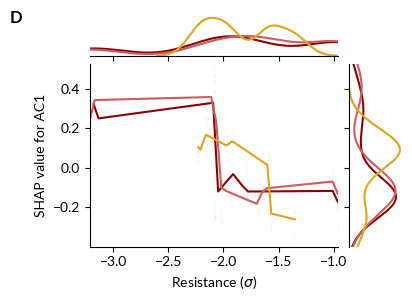

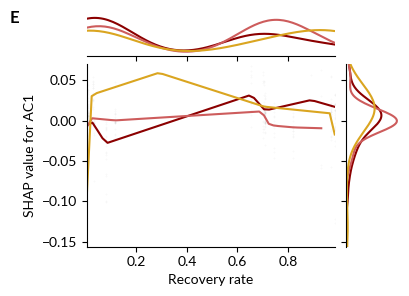

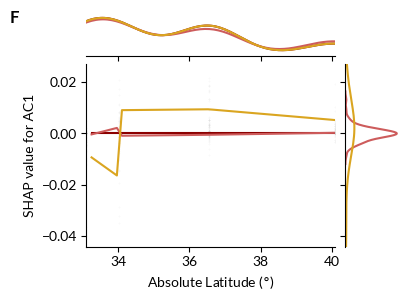

In [95]:
#Plot all SHAP plots with their marginals
shap_plot_marginals(0, 'resistance_sd_ratio', xlabel=r'Resistance ($\sigma$)', subplot_label='D')
plt.savefig(os.path.join('./plots/030_shap_resistance.png'), dpi = 700) #, bbox_inches='tight')
shap_plot_marginals(0, 'r', xlabel='Recovery rate', subplot_label='E')
plt.savefig(os.path.join('./plots/031_shap_recovery_rate.png'), dpi = 700) #, bbox_inches='tight')
shap_plot_marginals(0, 'abs_lat', xlabel=r'Absolute Latitude ($\degree$)', subplot_label='F')
plt.savefig(os.path.join('./plots/032_shap_latitude.png'), dpi = 700) #, bbox_inches='tight')

/tmp/ipykernel_3345006/1093007815.py:44: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(data=df_shap, x='x', y='shap_value', ax=ax, hue = 'VI', palette=cmap, showfliers=False, legend = legend_bool)
/tmp/ipykernel_3345006/1093007815.py:44: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.boxplot(data=df_shap, x='x', y='shap_value', ax=ax, hue = 'VI', palette=cmap, showfliers=False, legend = legend_bool)


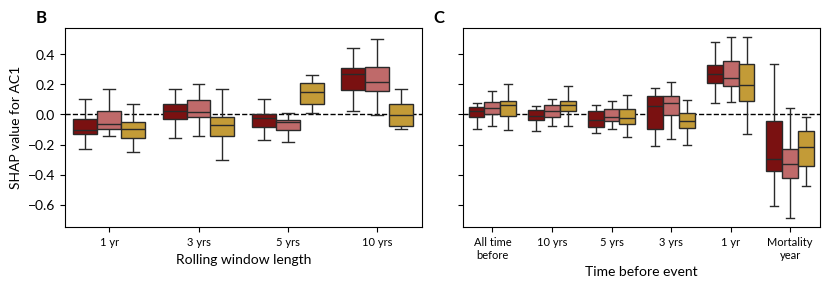

In [133]:
#Create categorical plot
fig, ax = plt.subplots(1, 2, figsize=(6.3*4/3, 3), sharey=True)
plot_shap_categorical(0, 'rolling_window', ax = ax[0], cat_order = [1, 3, 5, 10], cat_labels = ['1 yr', '3 yrs', '5 yrs', '10 yrs'])
ax[0].set_xlabel('Rolling window length')
plot_shap_categorical(0, 'Setup', ax = ax[1], cat_order = ['before', '10yr', '5yr', '3yr', '1yr', 'collapse_year'], 
                    cat_labels = ['All time\nbefore', '10 yrs', '5 yrs', '3 yrs', '1 yr', 'Mortality\nyear'])
ax[1].set_xlabel('Time before event')
for a in ax:
    a.axhline(0, color='black', linestyle='--', linewidth=1, zorder = -1)
#Add subplot labels
ax[0].text(-0.05, 1.05, 'B', transform=ax[0].transAxes, fontsize=12, fontweight='bold', va='center', ha='right')
ax[1].text(-0.05, 1.05, 'C', transform=ax[1].transAxes, fontsize=12, fontweight='bold', va='center', ha='right')
plt.tight_layout()
#Save plot
plt.savefig(os.path.join('./plots/033_shap_categorical.png'), dpi=700)

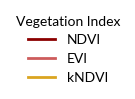

In [33]:
#Create freestanding legend for vegetation index colors
# Define colors and labels
colors = ['darkred', 'indianred', 'goldenrod']
labels = ['NDVI', 'EVI', 'kNDVI']

# Create custom line objects for the legend
lines = [Line2D([0], [0], color=color, lw=2) for color in colors]

# Create a small figure to hold only the legend
fig, ax = plt.subplots(figsize=(6.3 * 1/5, 1))  # width ≈ 1.05, height = 1
ax.axis('off')  # Turn off axes

# Add the legend
legend = ax.legend(lines, labels, title='Vegetation Index', loc='center', frameon=False)

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join('./plots/034_vegetation_index_legend.png'), dpi=700,  transparent=True)

#### Total joint figure

In [140]:
#Load all the separate plots
fig1 = plt.imread('./plots/030_importance_heatmap.png')
fig2 = plt.imread('./plots/030_shap_resistance.png')
fig3 = plt.imread('./plots/031_shap_recovery_rate.png')
fig4 = plt.imread('./plots/032_shap_latitude.png')
fig5 = plt.imread('./plots/033_shap_categorical.png')
fig_legend = plt.imread('./plots/034_vegetation_index_legend.png')

#Add legend onto plot
bottom_point = 3800
fig1[3800-fig_legend.shape[0]:3800, fig1.shape[1]-fig_legend.shape[1]:fig1.shape[1]] = fig_legend

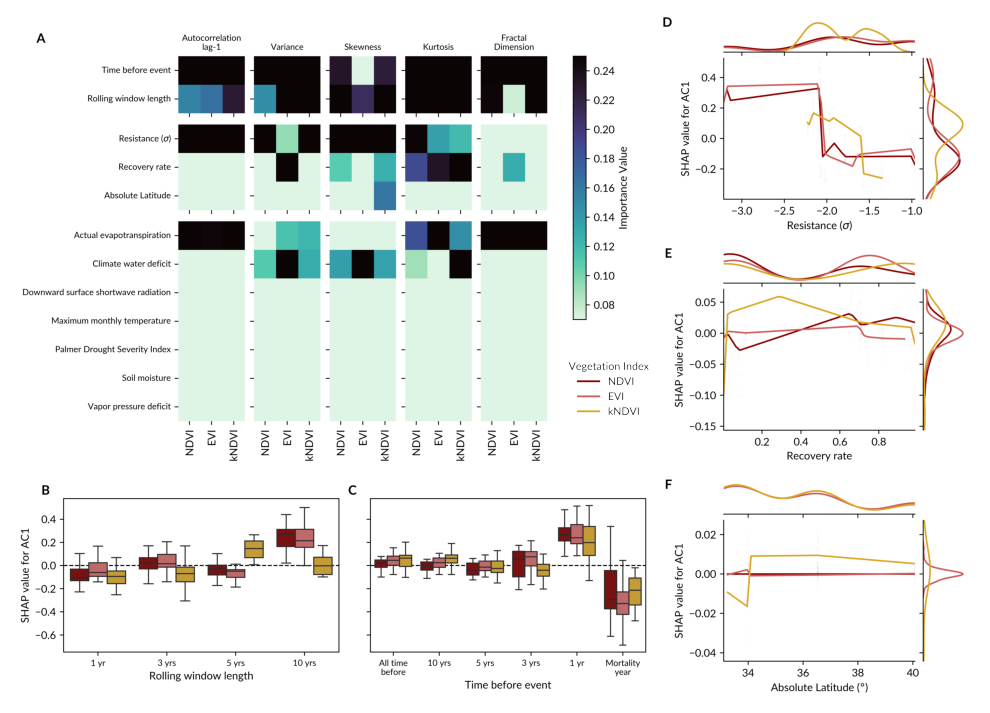

In [141]:
#Combine them in columns first
fig_left = np.vstack([fig1, fig5])
fig_right = np.vstack([fig2, fig3, fig4])

#combine those together
fig_combined = np.hstack([fig_left, fig_right])

#plot it all together
fig, ax = plt.subplots(1, 1, figsize = (6.3*2, 9))
ax.imshow(fig_combined)
ax.axis('off') # Hide the axes
plt.savefig('./plots/03_combined_plot.png', dpi = 700, bbox_inches = 'tight')

## Supplementary Figures


In [35]:
if not os.path.exists('./plots/supplementary/'):
    os.makedirs('./plots/supplementary/')
si_folder = './plots/supplementary/'

/tmp/ipykernel_3345006/1031782095.py:27: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(
/tmp/ipykernel_3345006/1031782095.py:27: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(
/tmp/ipykernel_3345006/1031782095.py:27: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(
/tmp/ipykernel_3345006/1031782095.py:27: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(
/tmp/ipykernel_3345006/1031782095.py:27: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(
/tmp/ipykernel_3345006/1031782095.py:27: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxenplot(


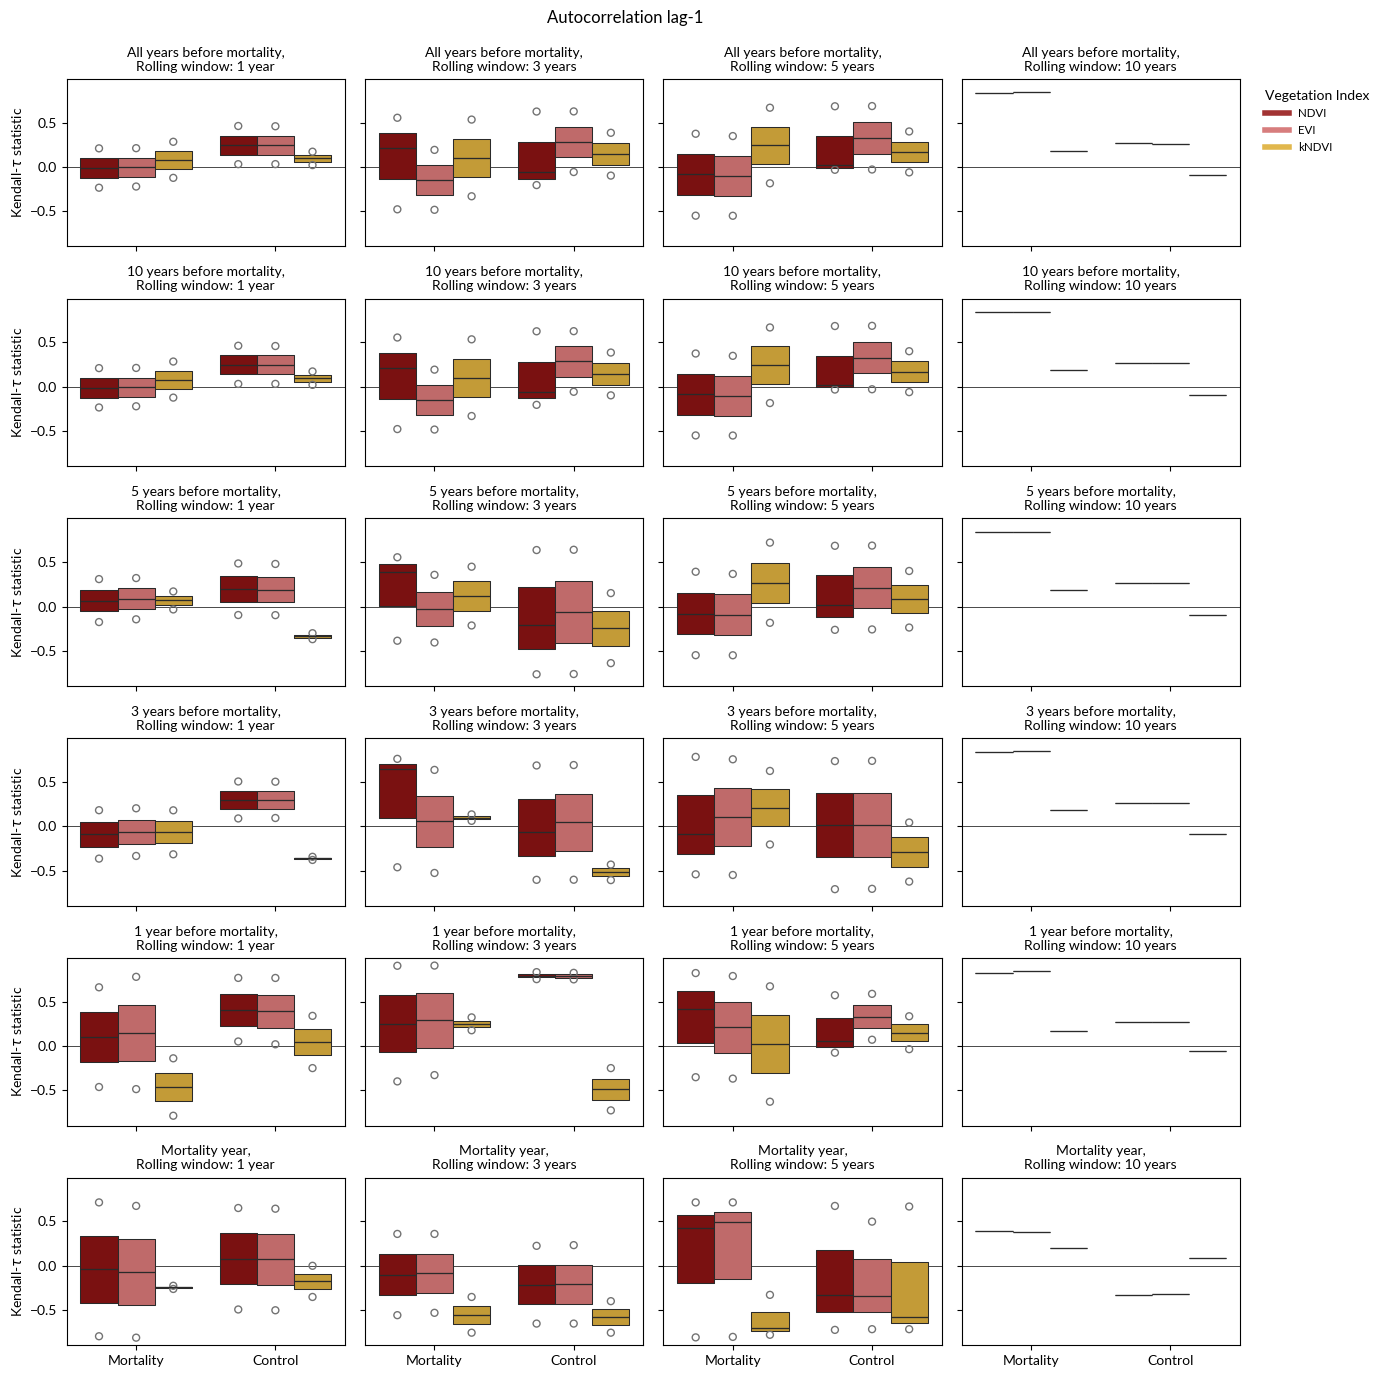

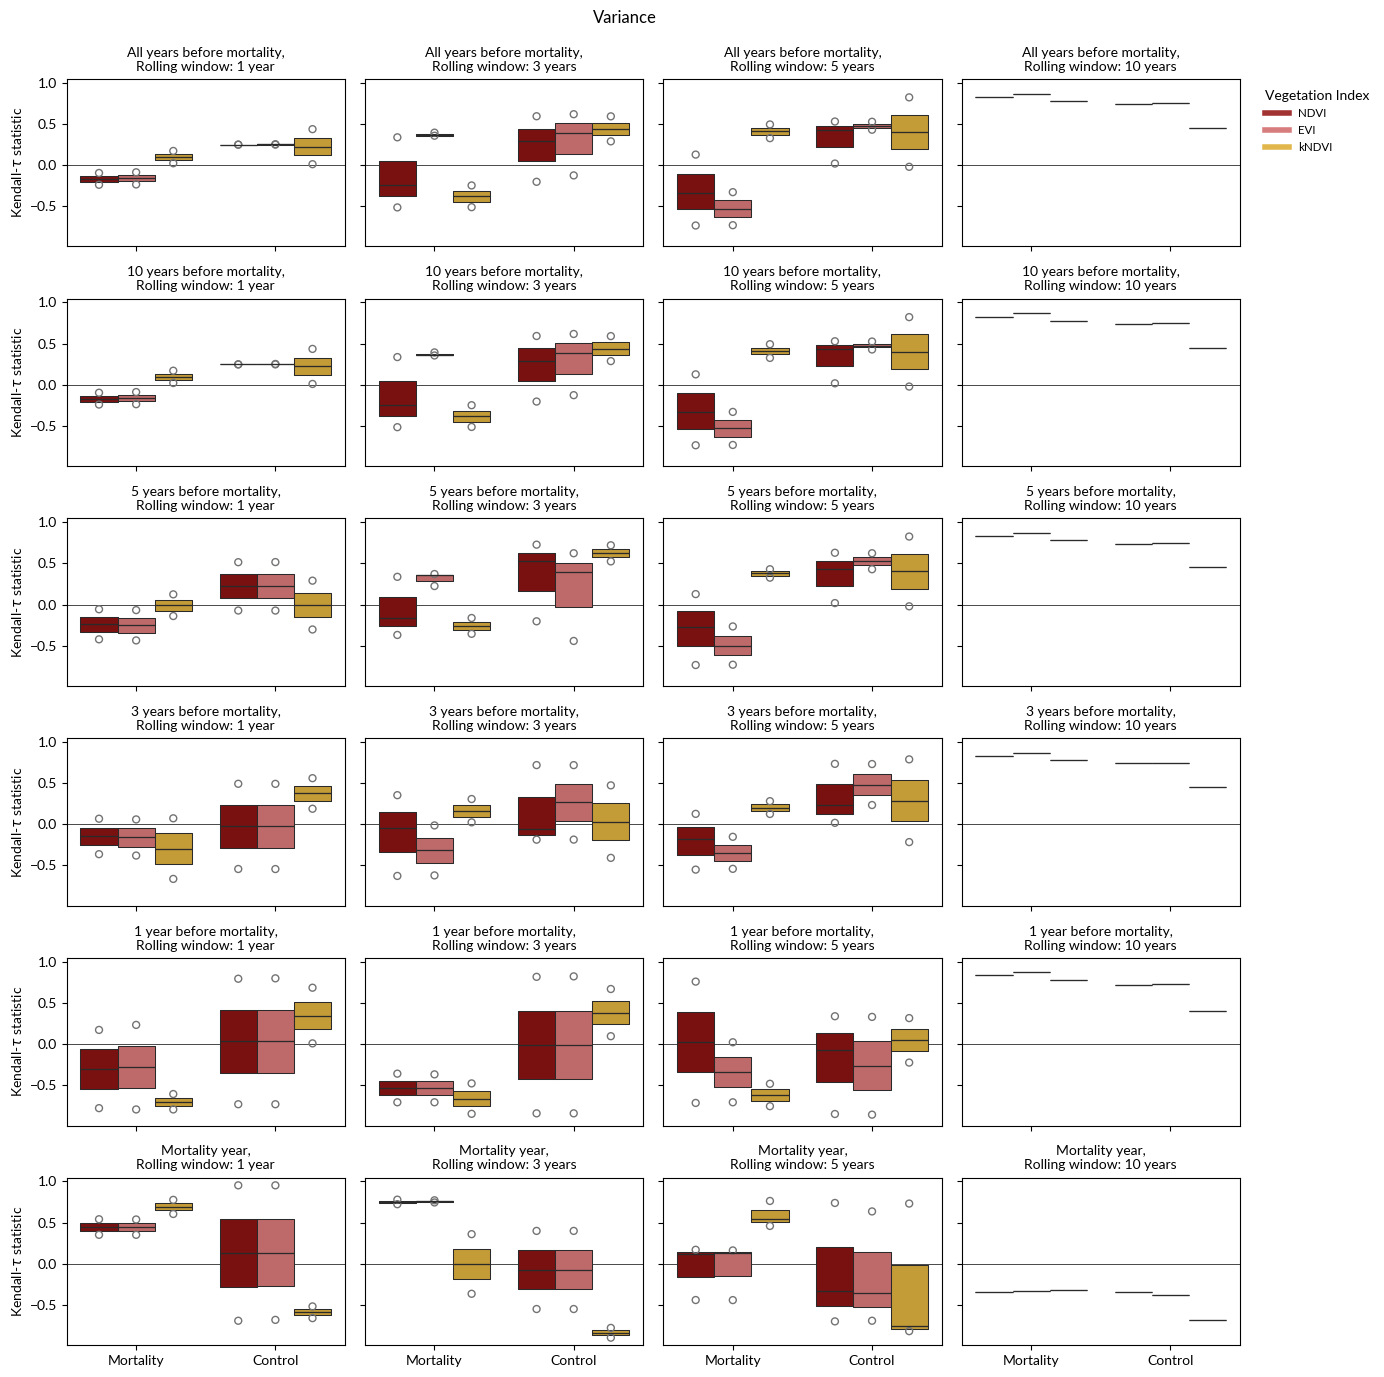

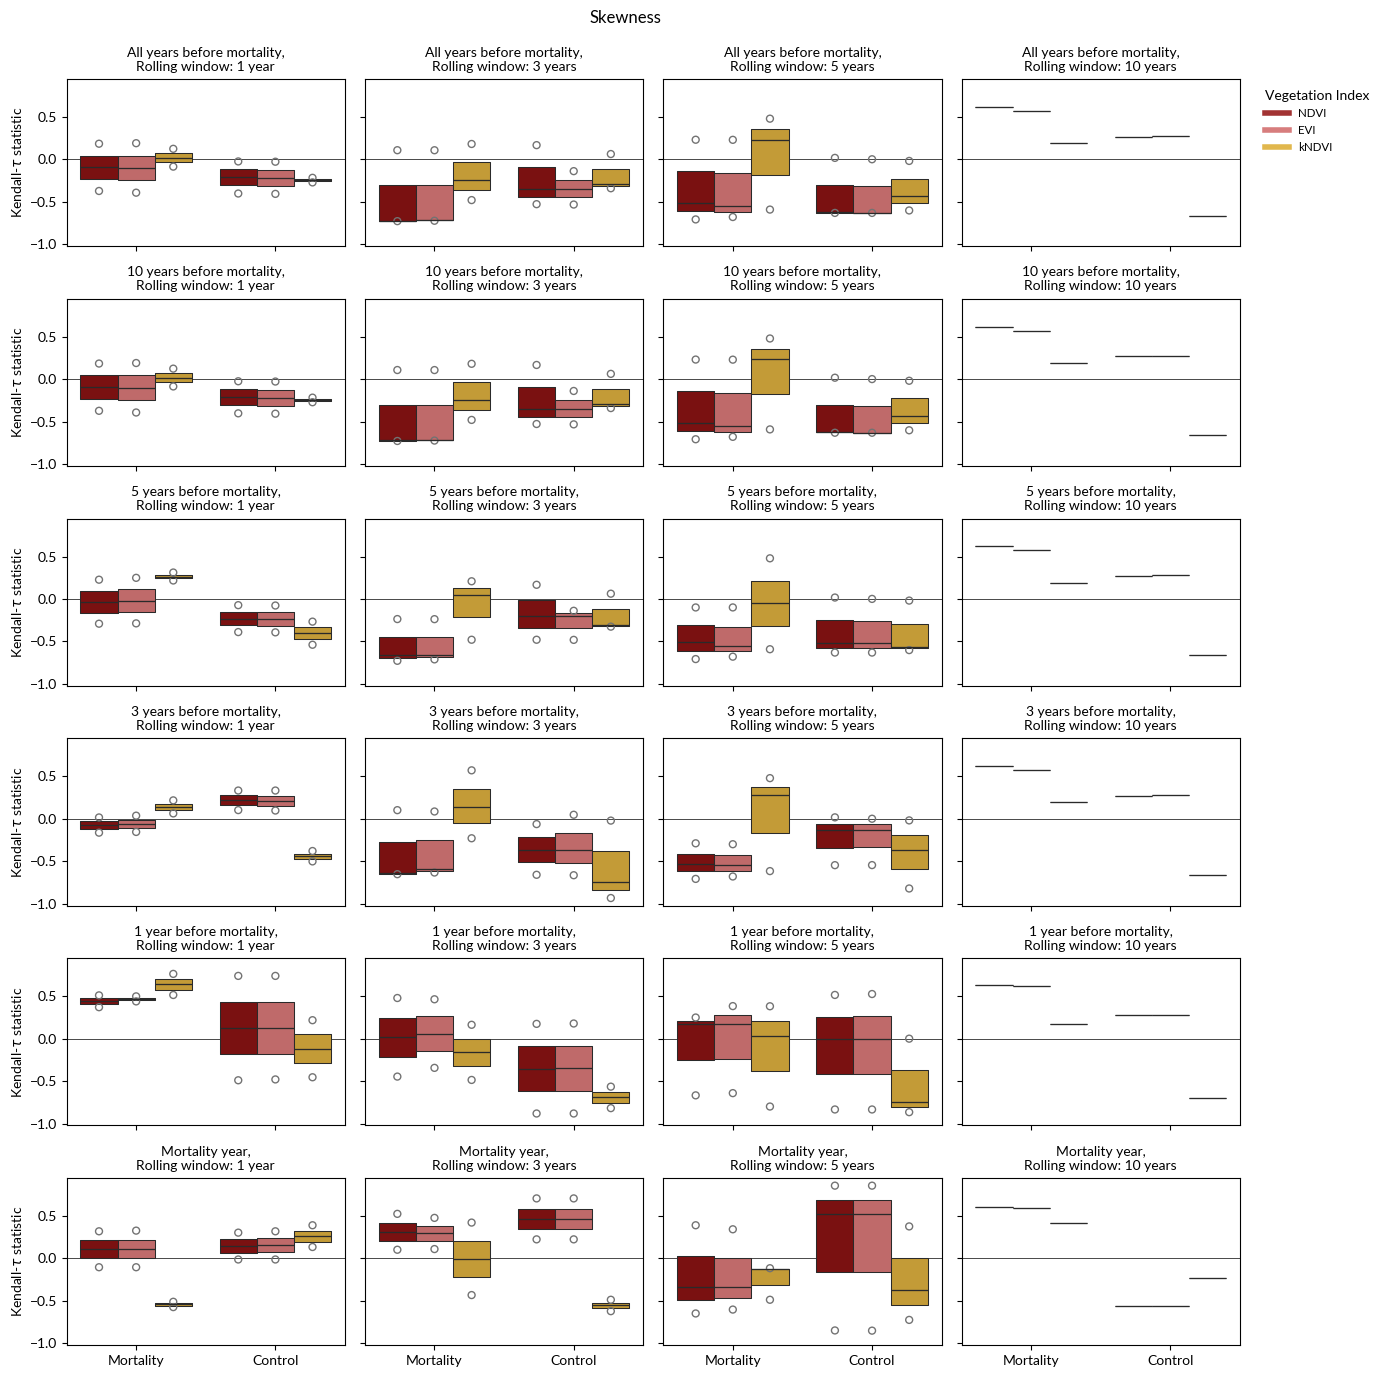

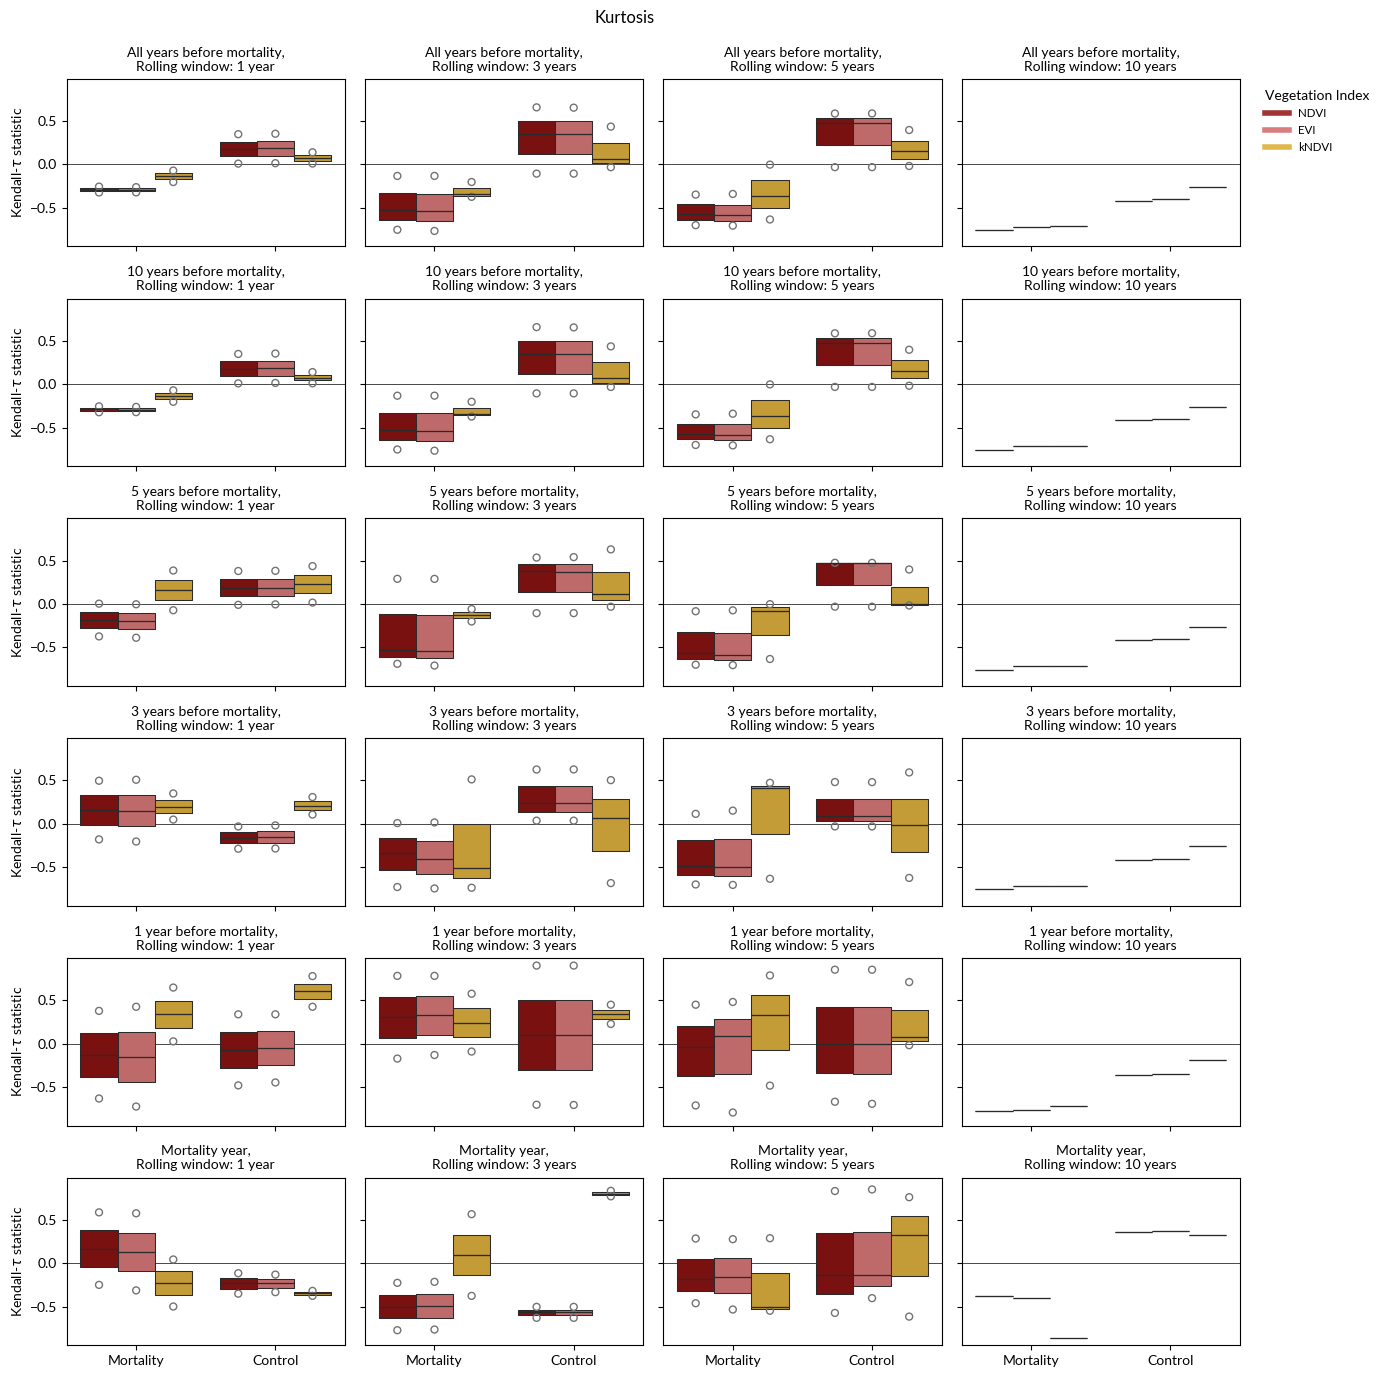

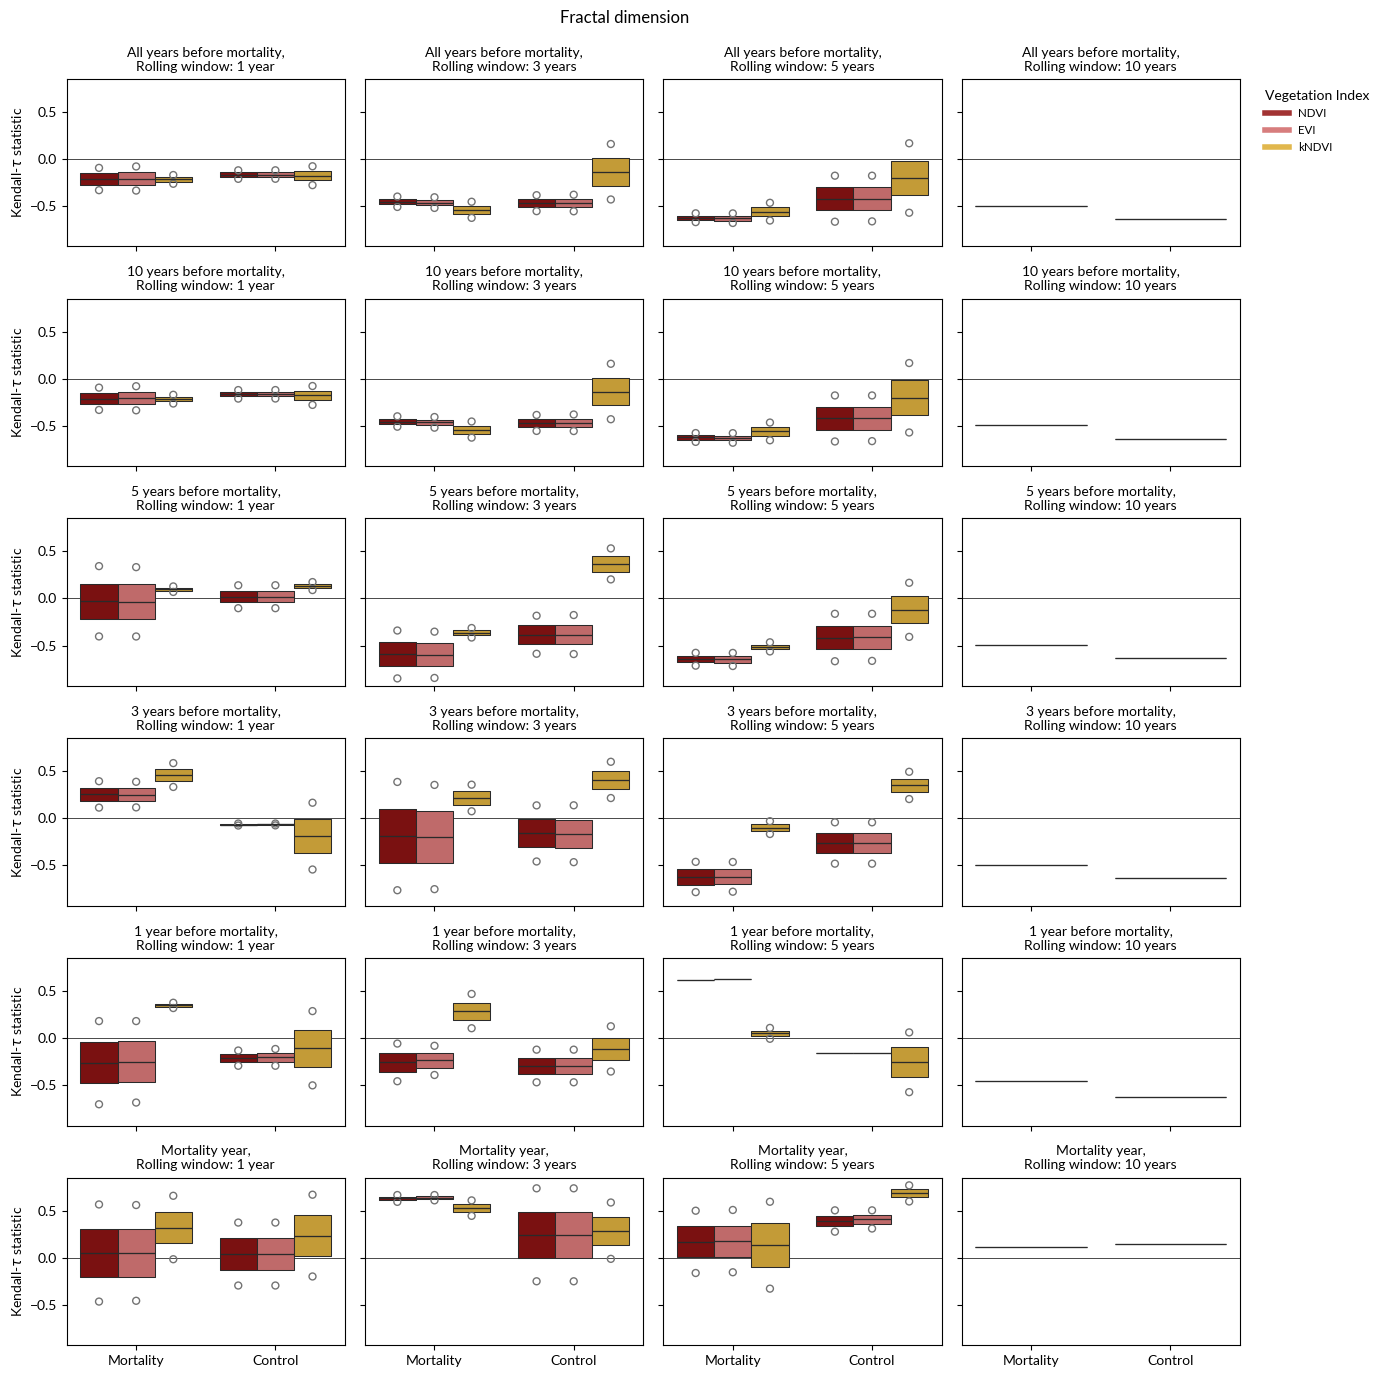

In [147]:
#Make plots for SI with with kt distributions per EWS and for different setups
def ews_distribution_si_plot(ews_choice, out_path = si_folder): 
    ews_labels = {
        'ews_ac1': 'Autocorrelation lag-1',
        'ews_var': 'Variance',
        'ews_skew': 'Skewness',
        'ews_kurt': 'Kurtosis',
        'ews_fd': 'Fractal dimension'}

    #Columns are rolling windows, rows are setups
    setups = ['before', '10yr', '5yr', '3yr', '1yr', 'collapse_year']
    rolling_windows = df_kt.rolling_window.unique()

    fig, axs = plt.subplots(len(setups), len(rolling_windows), 
                figsize=(6.3*2, 14), sharex=True, sharey=True)

    #Loop through setups and rolling windows and plot boxplot for each
    for i, setup in enumerate(setups):
        for j, rolling_window in enumerate(rolling_windows):
            ax = axs[i, j]
            #Filter data for this setup and rolling window
            data = df_kt.loc[((df_kt.EWS == ews_choice) & 
                                    (df_kt.true_pos_neg.isin(['true_pos', 'true_neg_ratio'])) &
                                    (df_kt.Setup == setup) & (df_kt.rolling_window == rolling_window))]
            
            if not data.empty:
                sns.boxenplot(
                    data=data,
                    x='true_pos_neg', y='kt_stat', hue='VI',
                    ax=ax, palette=colors, legend=False
                )
                if setup == 'collapse_year':
                    setup_text = 'Mortality year'
                elif setup == 'before':
                    setup_text = 'All years before mortality'
                else:
                    setup_mini = setup.split('yr')[0]
                    if setup_mini == '1':
                        setup_text = '1 year before mortality'
                    else:
                        setup_text = f'{setup_mini} years before mortality'
                if rolling_window == 1:
                    rw_text = '1 year'
                else:
                    rw_text = f'{rolling_window} years'
                
                ax.set_title(f'{setup_text},\nRolling window: {rw_text}', fontsize = 10)
                ax.set_xlabel('')
                ax.set_ylabel(r'Kendall-$\tau$ statistic')
                ax.axhline(0, color='black', linewidth=0.5, zorder=-1)
                ax.set_xticks([0, 1])
                ax.set_xticklabels(['Mortality', 'Control'])
            else:
                ax.set_visible(False)  # Hide empty subplots
    fig.suptitle(f'{ews_labels[ews_choice]}\n')

    #Make manual legend, one for the key colors and then one for the darkness based on grey
    # Create a custom legend
    handles = []
    for color in colors:
        handles.append(plt.Line2D([0], [0], color=color, lw=4, label=color, alpha = .8))
    # Add the legend to the figure
    fig.legend(
        handles, ['NDVI', 'EVI', 'kNDVI'],
        loc='upper left',
        bbox_to_anchor=(1, .93),  # Adjust as needed
        title='Vegetation Index',
        fontsize='small', frameon = False, alignment = 'left'
    )

    plt.tight_layout()
    #Save to figure
    plt.savefig(os.path.join(out_path, f'ews_distribution_{ews_choice}.png'),
                dpi=700, bbox_inches='tight', transparent=True)

ews_distribution_si_plot('ews_ac1')
ews_distribution_si_plot('ews_var')
ews_distribution_si_plot('ews_skew')
ews_distribution_si_plot('ews_kurt')
ews_distribution_si_plot('ews_fd')

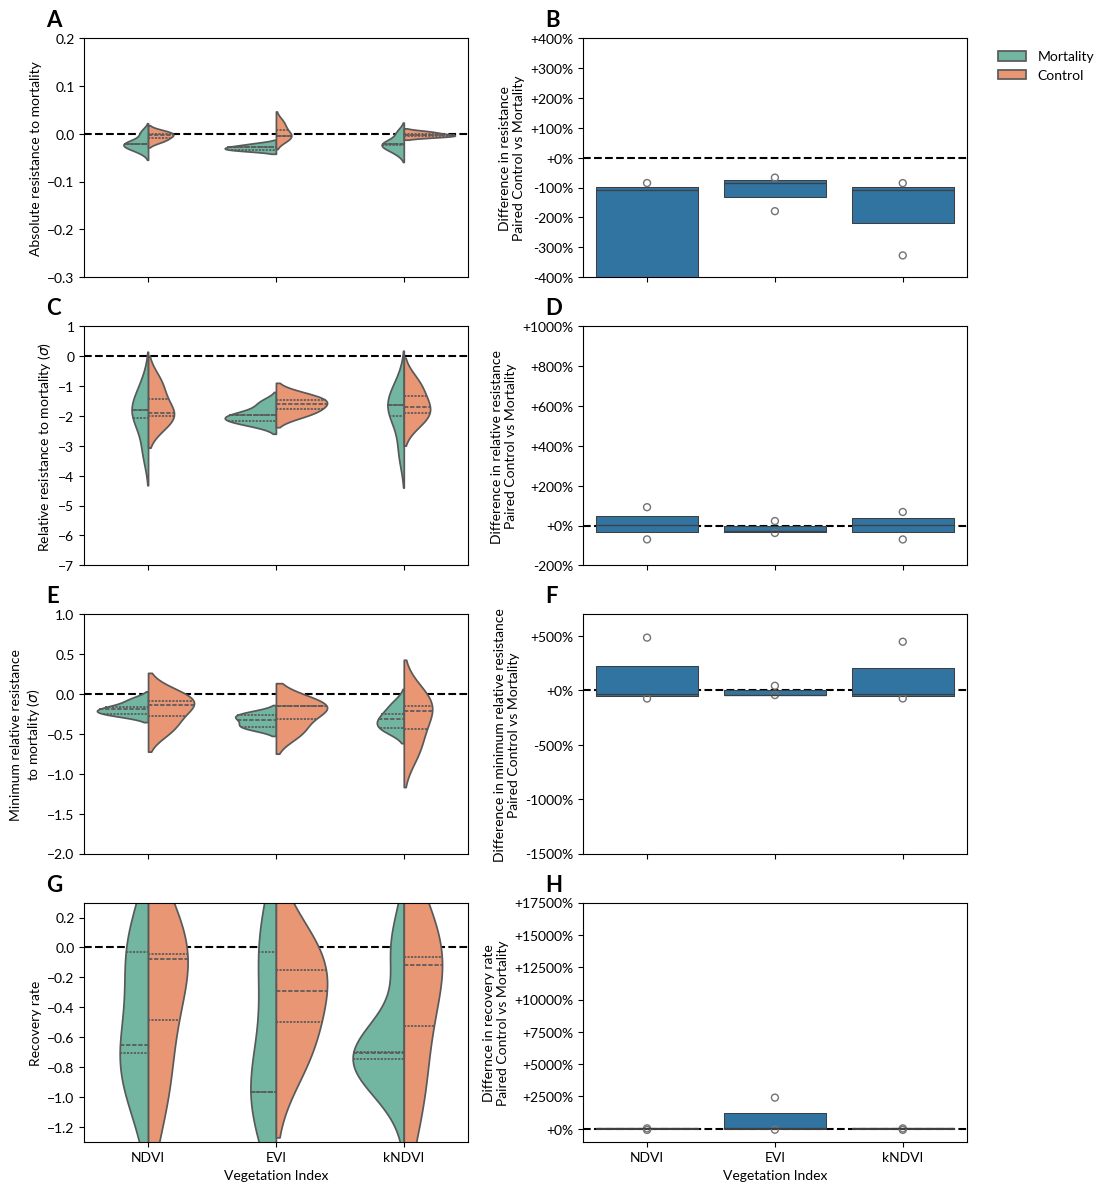

In [160]:
#FIGURE 6: Comparison of True Mortality and Control locations or resistance and recovery rates

#NOTE: the axis limits set here work for the full dataset and might look weird for a subset

#Prepare the dataset
dtemp = data.pivot(index = ['entry_id', 'VI'], columns = 'true_pos_neg', values = 'resistance').reset_index(drop = False)
dtemp['resistance_ratio'] = dtemp.Control / dtemp.Mortality - 1
#Append this 
dpivot = dtemp.copy().drop(columns = ['Control', 'Mortality'])
#Also compute this for resistance_sd_ratio
dtemp = data.pivot(index = ['entry_id', 'VI'], columns = 'true_pos_neg', values = 'resistance_sd_ratio').reset_index(drop = False)
dtemp['resistance_sd_ratio'] = dtemp.Control / dtemp.Mortality - 1
#Append this
dpivot = pd.merge(dpivot, dtemp[['entry_id', 'VI', 'resistance_sd_ratio']], on=['entry_id', 'VI'], how='left')
#Also compute this for resistance_max
dtemp = data.pivot(index = ['entry_id', 'VI'], columns = 'true_pos_neg', values = 'resistance_max_rel').reset_index(drop = False)
dtemp['resistance_max_rel_ratio'] = dtemp.Control / dtemp.Mortality - 1
#Append this
dpivot = pd.merge(dpivot, dtemp[['entry_id', 'VI', 'resistance_max_rel_ratio']], on=['entry_id', 'VI'], how='left')
#Also compute this for r 
dtemp = data.pivot(index = ['entry_id', 'VI'], columns = 'true_pos_neg', values = 'r').reset_index(drop = False)
dtemp['r_ratio'] = dtemp.Control / dtemp.Mortality - 1
#Append this
dpivot = pd.merge(dpivot, dtemp[['entry_id', 'VI', 'r_ratio']], on=['entry_id', 'VI'], how='left')

#Compare recovery rate and resistance between true pos, neg etc.
def set_ax_limits(ax, df, var, quant = .99):
    """
    Set the y-axis limits of the axes to the quantiles of the data.
    """
    q = df[var].quantile([1-quant, quant]).values
    ax.set_ylim(q[0], q[1])
    return ax

# Example formatter function
def percent_with_sign(x, pos):
    return f"{x*100:+.0f}%"
    
fig, ax = plt.subplots(4, 2, figsize=(5.6*2, 12), sharex = True)
#First plot: absolute resistance
sns.violinplot(x='VI', y='resistance', hue = 'true_pos_neg',
                data=data, 
                palette="Set2", ax = ax[0, 0], order=['NDVI', 'EVI', 'kNDVI'],
                hue_order=['Mortality', 'Control'], split = True, inner = 'quart', legend = True)
#ax.set_ylim(-12, 1)
#ax[0] = set_ax_limits(ax[0], data, 'resistance')
ax[0, 0].set_ylim(-.3, .2)
ax[0, 0].set_ylabel('Absolute resistance to mortality')

#Plot the ratios of respective pairs
sns.boxenplot(x = 'VI', y  = 'resistance_ratio',
                data = dpivot, ax = ax[0, 1], order=['NDVI', 'EVI', 'kNDVI'],  legend = False)
ax[0, 1].set_ylabel('Difference in resistance\nPaired Control vs Mortality')
ax[0, 1].set_ylim(-4, 4)
#ax[0, 1] = set_ax_limits(ax[0, 1], dpivot, 'resistance_ratio', quant = .995)

# Get legend handles and labels from ax[0, 0]
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[0, 0].legend_.remove()  # Remove the legend from ax[0, 0]
# Create legend next to ax[0, 1]
ax[0, 1].legend(handles, labels, title='', loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

#Second plot: resistance in SD
sns.violinplot(x='VI', y='resistance_sd_ratio', hue = 'true_pos_neg',
                data=data, 
                palette="Set2", ax = ax[1, 0], order=['NDVI', 'EVI', 'kNDVI'],
                hue_order=['Mortality', 'Control'], legend = False, split = True, inner = 'quart')
ax[1, 0].set_ylabel(r'Relative resistance to mortality ($\sigma$)')
#ax[1, 0] = set_ax_limits(ax[1], data, 'resistance_sd_ratio')
ax[1, 0].set_ylim(-7, 1)

sns.boxenplot(x = 'VI', y  = 'resistance_sd_ratio',
                data = dpivot,ax = ax[1, 1], order=['NDVI', 'EVI', 'kNDVI'],  legend = False)
ax[1, 1].set_ylabel('Difference in relative resistance\nPaired Control vs Mortality')
ax[1, 1].set_ylim(-2, 10)
#ax[1, 1] = set_ax_limits(ax[1, 1], dpivot, 'resistance_sd_ratio', quant = .995)

#Third plot: Maximum relative resistance
sns.violinplot(x='VI', y='resistance_max_rel', hue = 'true_pos_neg',
                data=data, 
                palette="Set2", ax = ax[2, 0], order=['NDVI', 'EVI', 'kNDVI'],
                hue_order=['Mortality', 'Control'], legend = False, split = True, inner = 'quart')
ax[2, 0].set_ylabel('Minimum relative resistance\nto mortality ($\sigma$)')
#ax[2, 0] = set_ax_limits(ax[2], data, 'resistance_max_rel')
ax[2, 0].set_ylim(-2, 1)

sns.boxenplot(x = 'VI', y  = 'resistance_max_rel_ratio',
                data = dpivot, ax = ax[2, 1], order=['NDVI', 'EVI', 'kNDVI'],  legend = False)
ax[2, 1].set_ylabel('Difference in minimum relative resistance\nPaired Control vs Mortality')
#ax[2, 1] = set_ax_limits(ax[2, 1], dpivot, 'resistance_max_rel_ratio', quant = .999)
ax[2, 1].set_ylim(-15, 7)


#Second plot: difference in recovery rate
sns.violinplot(x = 'VI', y = 'r', hue = 'true_pos_neg',
                data=data, 
                palette="Set2", ax = ax[3, 0], order=['NDVI', 'EVI', 'kNDVI'],
                hue_order=['Mortality', 'Control'], legend = False, split = True, inner = 'quart')
ax[3, 0].set_ylabel('Recovery rate')
#ax[3] = set_ax_limits(ax[3], data, 'r')
ax[3, 0].set_ylim(-1.3, .3)

sns.boxenplot(x = 'VI', y  = 'r_ratio',
                data = dpivot, ax = ax[3, 1], order=['NDVI', 'EVI', 'kNDVI'],  legend = False)
ax[3, 1].set_ylabel('Differnce in recovery rate\nPaired Control vs Mortality')
ax[3, 1] = set_ax_limits(ax[3, 1], dpivot, 'r_ratio', quant = .999)
ax[3, 1].set_ylim(-10, 175)

for i, a in enumerate(ax.flatten()):
    a.axhline(0, color='black', linestyle='--', zorder = -1)
    a.set_xlabel('')
    a.text(-0.1, 1.05, string.ascii_uppercase[i], transform = a.transAxes, 
                size = 16, weight = 'bold')
    if i > 5:
        a.set_xlabel('Vegetation Index')
for i, a in enumerate(ax[:, 1].flatten()):
    a.yaxis.set_major_formatter(FuncFormatter(percent_with_sign))

#Add subplot labels
plt.tight_layout()
plt.savefig(os.path.join(si_folder, 'comparison_mortality_control_resistance_recovery'), dpi = 700, bbox_inches='tight')

/tmp/ipykernel_3345006/2893359235.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mortality', 'Control'])
/tmp/ipykernel_3345006/2893359235.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mortality', 'Control'])
/tmp/ipykernel_3345006/2893359235.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mortality', 'Control'])
/tmp/ipykernel_3345006/2893359235.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Mortality', 'Control'])
/tmp/ipykernel_3345006/2893359235.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_

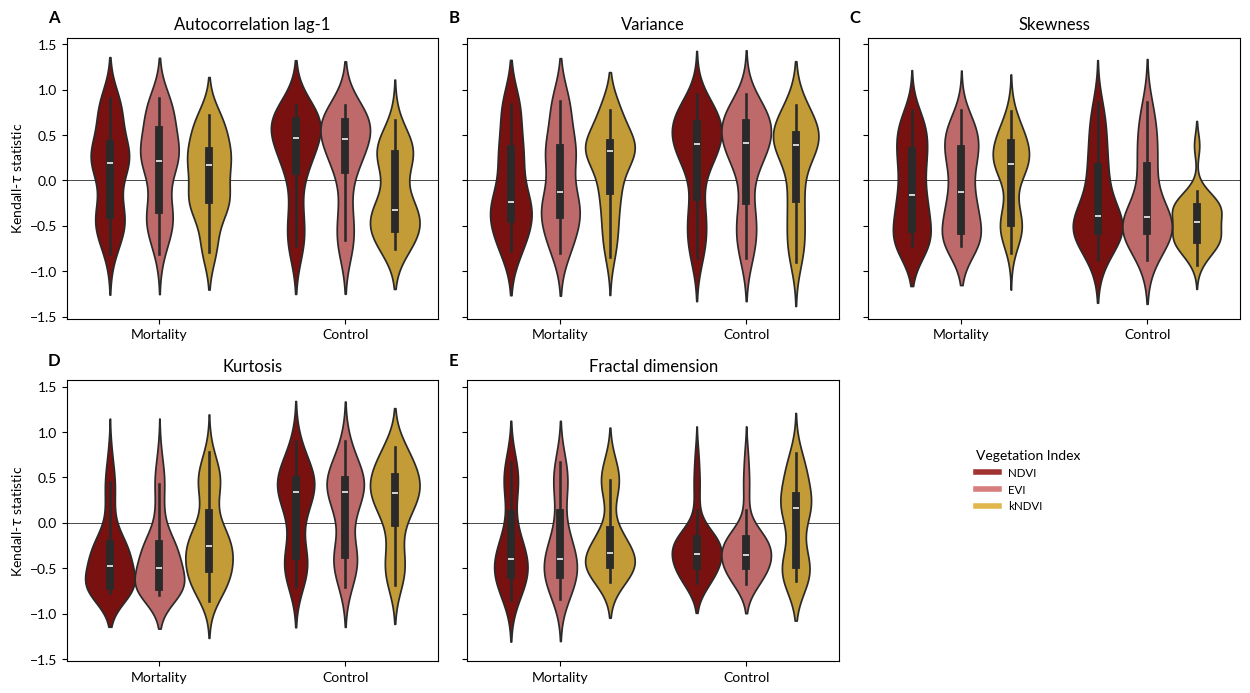

In [163]:
# FIGURE 7: Version of Figure 4 in main document, but showing only statistically significant points

#Plot the raw kt trend values

# Create the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(6.3*2, 7), sharex=False, sharey=True)

titles = ['Autocorrelation lag-1', 'Variance', 'Skewness', 'Kurtosis', 'Fractal dimension']
colors = ['darkred', 'indianred', 'goldenrod']
labels = ['NDVI', 'EVI', 'kNDVI']
#Make color palette from this

# Compute dodge offsets
x_order = ['true_pos', 'true_neg_ratio']
hue_order = labels

x_map = {k: i for i, k in enumerate(x_order)}
hue_map = {k: i for i, k in enumerate(hue_order)}

n_hues = len(hue_order)
width = 0.8
dodge_amount = width / n_hues

#Create colormap for pval_sig with black for significant and grey for not significant
cmap = sns.color_palette(['lightgrey', 'black'])

# Map to numeric x positions
x_vals = df_kt['true_pos_neg'].map(x_map).to_numpy()
hue_vals = df_kt['VI'].map(hue_map).to_numpy()
x_offsets = (hue_vals - (n_hues - 1) / 2) * dodge_amount
x_scatter = x_vals + x_offsets
df_kt['xscatter'] = x_scatter

#Make new color list that is just dark
labels = ['A', 'B', 'C', 'D', 'E']
axs = axs.flatten()


for i, (ews, label, title) in enumerate(zip(
        ['ews_ac1', 'ews_var', 'ews_skew', 'ews_kurt', 'ews_fd'], labels, titles)):
    
    ax = axs[i]
    leg_bool = (i == 0)
    
    sns.violinplot(
        data=df_kt.loc[((df_kt.EWS == ews) & (df_kt.true_pos_neg.isin(['true_pos', 'true_neg_ratio'])) & (df_kt.pval_sig == True))],
        x='true_pos_neg', y='kt_stat', hue='VI',
        ax=ax, palette=colors, legend=leg_bool, #inner = None, dodge = True, alpha = .8
    )

    # Add subplot label (A–E)
    ax.text(-0.05, 1.1, label, transform=ax.transAxes, fontsize=12, fontweight='bold', va='top')
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel(r'Kendall-$\tau$ statistic')
    ax.set_xticklabels(['Mortality', 'Control'])
    ax.axhline(0, color = 'black', linewidth = .5, zorder = -1)

# Turn off the unused sixth subplot
axs[5].axis('off')

#Make manual legend, one for the key colors and then one for the darkness based on grey
# Create a custom legend
handles = []
for color in colors:
    handles.append(plt.Line2D([0], [0], color=color, lw=4, label=color, alpha = .8))
# Add the legend to the figure
fig.legend(
    handles, ['NDVI', 'EVI', 'kNDVI'],
    loc='upper left',
    bbox_to_anchor=(.77, .37),  # Adjust as needed
    title='Vegetation Index',
    fontsize='small', frameon = False, alignment = 'left'
)

# Remove internal subplot legend
axs[0].get_legend().remove()

plt.tight_layout()

plt.savefig(
    os.path.join(si_folder, 'ews_kt_trends_only_significant.png'),
    dpi=700, bbox_inches='tight', transparent=True
)



In [36]:
#FIGURE 13: SHAP values for methodological choices per EWS and VI
fig, ax = plt.subplots(5, 2, figsize=(6.3*2,8*2), sharey='row', sharex = 'col')
ews = ['AC1', 'variance', 'skewness', 'kurtosis', 'fractal dimension']
for i in range(5):
    if i == 0:
        legend_bool = True
    else:
        legend_bool = False
    plot_shap_categorical(i, 'rolling_window', ax = ax[i, 0], cat_order = [1, 3, 5, 10],  cat_labels = ['1 yr', '3 yrs', '5 yrs', '10 yrs'], 
                        ylabel = f'SHAP value for {ews[i]}')
    ax[i, 0].set_xlabel('Rolling window length')
    #Add letters to subplots
    ax[i, 0].text(-0.03, 1.07, chr(65 + i*2), transform=ax[i, 0].transAxes, fontsize=12, fontweight='bold', va='center', ha='right')
    plot_shap_categorical(i, 'Setup', ax = ax[i, 1], cat_order = ['before', '10yr', '5yr', '3yr', '1yr', 'collapse_year'], 
                    cat_labels = ['All time\nbefore', '10 yrs', '5 yrs', '3 yrs', '1 yr', 'Mortality\nyear'], legend_bool = legend_bool)
    ax[i, 1].set_xlabel('Time before event')
    #Add letters to subplots
    ax[i, 1].text(-0.03, 1.07, chr(66 + i*2), transform=ax[i, 1].transAxes, fontsize=12, fontweight='bold', va='center', ha='right')
    #Set the y-label for the

for a in ax.flatten():
    a.axhline(0, color='black', linestyle='--', linewidth=1, zorder = -1)
#Move the legend to the top right of the global plot
ax[0, 1].legend(loc='upper left', bbox_to_anchor=(1.01, 1), title='Vegetation Index')

#Save figure for appendix
plt.savefig(os.path.join(si_folder, 'shap_categorical_supplements.png'), dpi=700, bbox_inches='tight')

AC1 resistance_sd_ratio
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


AC1 r
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


AC1 abs_lat
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

AC1 aet_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


AC1 def_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

AC1 soil_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

AC1 srad_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

AC1 tmax_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

AC1 vpd_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

AC1 PDSI_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

variance resistance_sd_ratio
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


variance r
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


variance abs_lat
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

variance aet_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


variance def_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

variance soil_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

variance srad_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

variance tmax_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

variance vpd_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

variance PDSI_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

skewness resistance_sd_ratio
hue is defined


/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/seaborn/axisgrid.py:1696: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure(figsize=(height, height))
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: Runti

skewness r
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


skewness abs_lat
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

skewness aet_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


skewness def_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

skewness soil_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

skewness srad_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

skewness tmax_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

skewness vpd_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

skewness PDSI_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

kurtosis resistance_sd_ratio
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


kurtosis r
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


kurtosis abs_lat
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

kurtosis aet_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


kurtosis def_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

kurtosis soil_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

kurtosis srad_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

kurtosis tmax_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

kurtosis vpd_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

kurtosis PDSI_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

fractal dimension resistance_sd_ratio
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


fractal dimension r
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


fractal dimension abs_lat
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

fractal dimension aet_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


fractal dimension def_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

fractal dimension soil_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

fractal dimension srad_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

fractal dimension tmax_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

fractal dimension vpd_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

fractal dimension PDSI_year_1
hue is defined


/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_3345006/120980033.py:54: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(smooths, axis=1)
/home/nielja/miniconda3/envs/geodata/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipyke

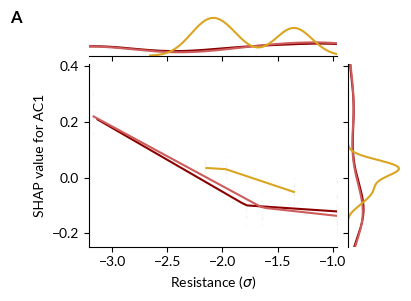

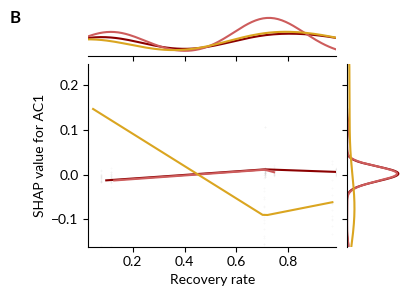

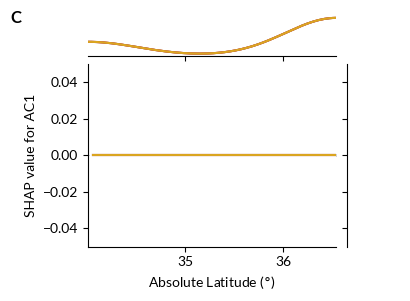

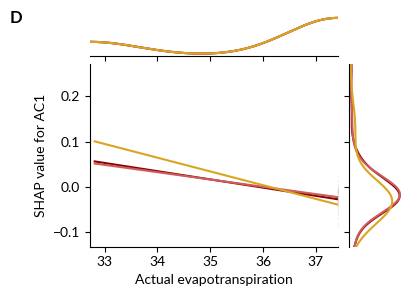

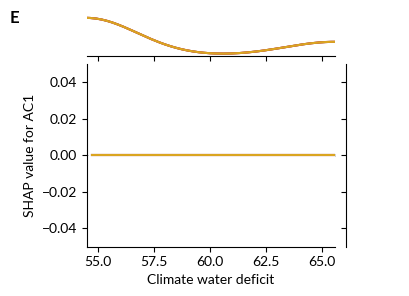

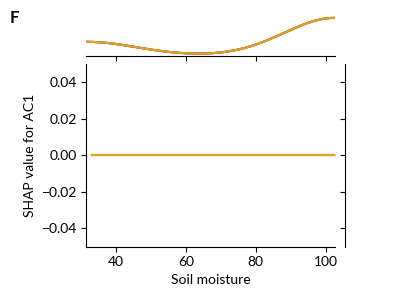

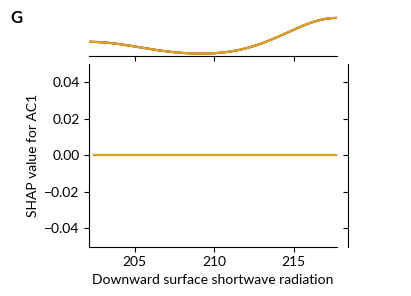

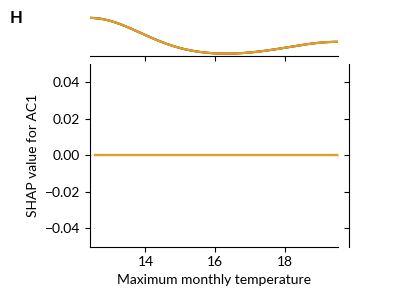

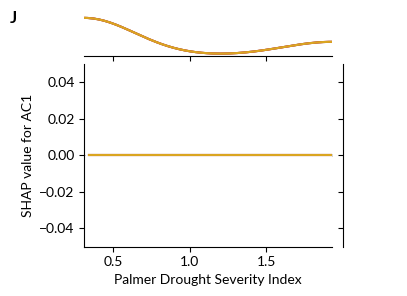

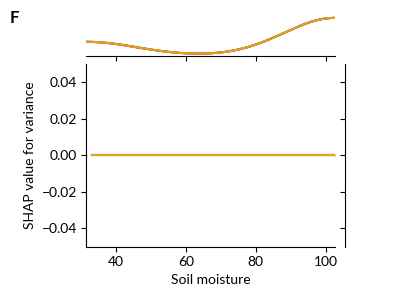

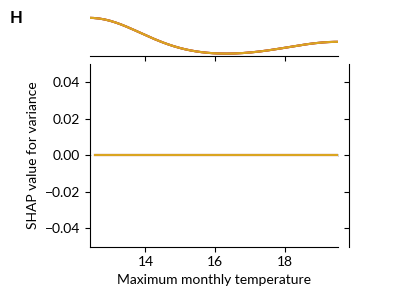

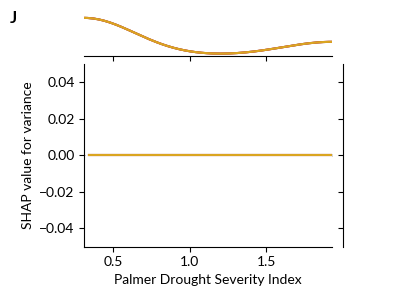

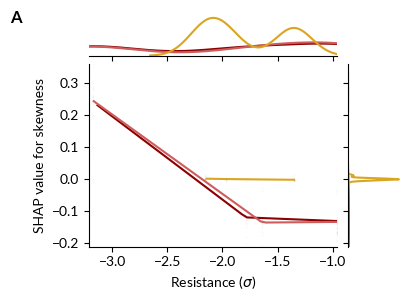

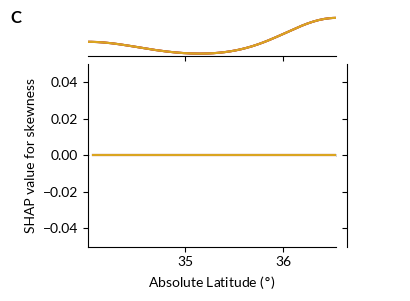

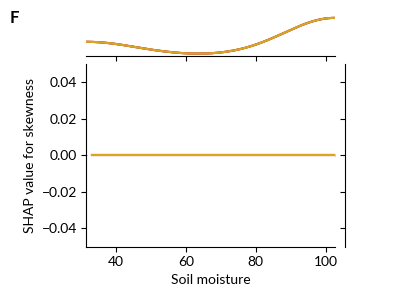

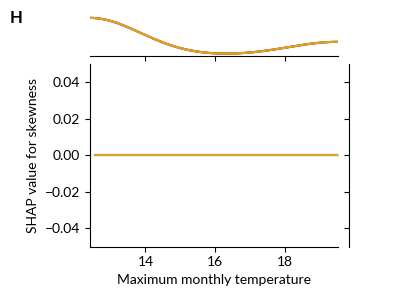

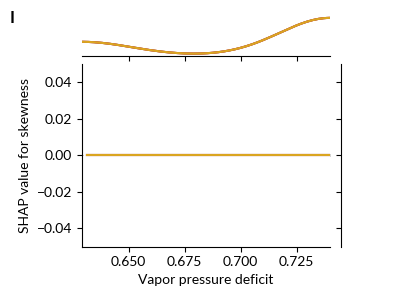

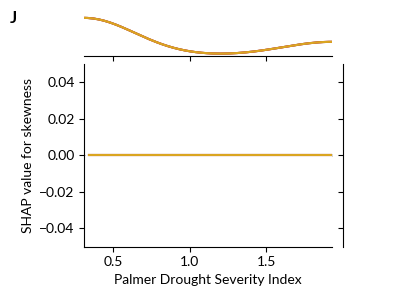

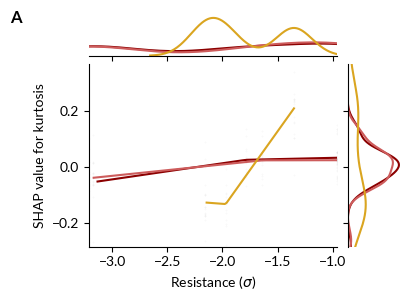

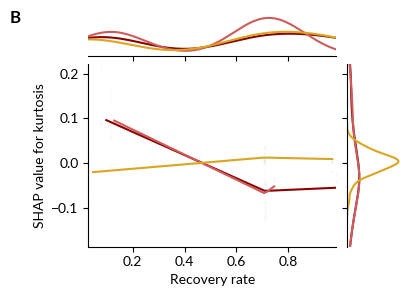

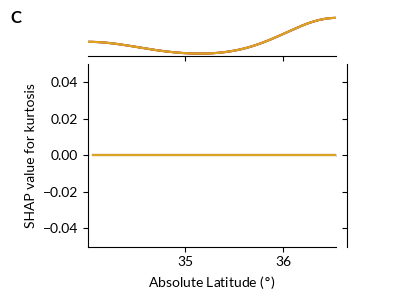

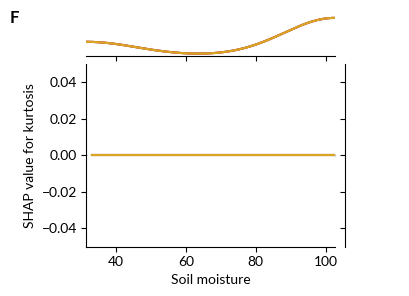

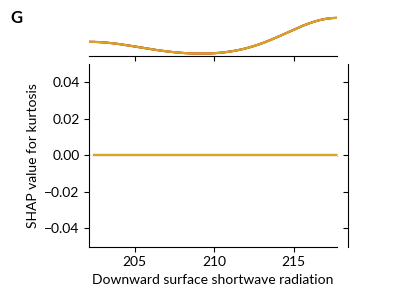

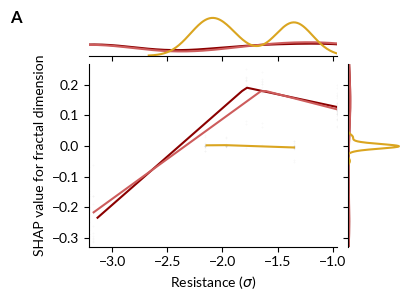

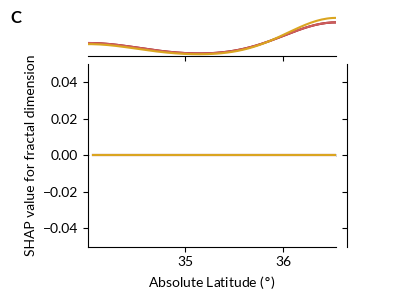

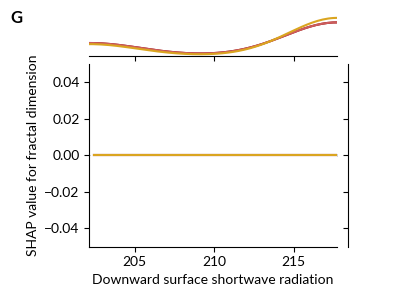

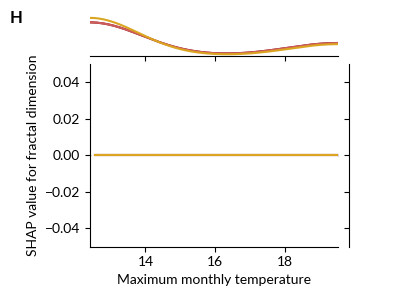

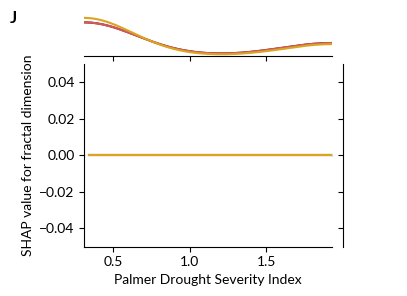

In [38]:
#FIGURE 14: SHAP values for continuous variables per EWS and VI
driver_orig = ['resistance_sd_ratio', 'r', 'abs_lat', 'aet_year_1', 'def_year_1',
       'soil_year_1', 'srad_year_1', 'tmax_year_1', 'vpd_year_1',
       'PDSI_year_1']
driver_labels = [   r'Resistance ($\sigma$)', 'Recovery rate',r'Absolute Latitude ($\degree$)', 'Actual evapotranspiration', 'Climate water deficit', 'Soil moisture',
    'Downward surface shortwave radiation', 'Maximum monthly temperature', 'Vapor pressure deficit', 'Palmer Drought Severity Index']
#Make this into dict
driver_map = dict(zip(driver_orig, driver_labels))
for n, ews in enumerate(['AC1', 'variance', 'skewness', 'kurtosis', 'fractal dimension']):
    for i, d in enumerate(driver_orig):
        print(ews, d)
        shap_plot_marginals(n, d, xlabel=driver_map[d], subplot_label=chr(65 + i), ylabel = f'SHAP value for {ews}')
        plt.savefig(os.path.join(si_folder, f'shap_{ews}_driver_{str(i).zfill(2)}_{d}.png'), dpi=700)

In [ ]:
# Combine all continuous SHAP plots into one per EWS with legend in last slot
# ---------- Helpers ----------
def ensure_rgb(img):
    """Convert RGBA (4 channels) to RGB (3 channels)."""
    if img.shape[2] == 4:
        return img[..., :3]
    return img

def pad_to_height(img, target_height):
    """Pad image to target height with white background."""
    if img.shape[0] == target_height:
        return img
    pad = target_height - img.shape[0]
    top, bottom = pad // 2, pad - pad // 2
    return np.pad(img, ((top, bottom), (0, 0), (0, 0)),
                  mode="constant", constant_values=1)

def pad_to_width(img, target_width):
    """Pad image to target width with white background."""
    if img.shape[1] == target_width:
        return img
    pad = target_width - img.shape[1]
    left, right = pad // 2, pad - pad // 2
    return np.pad(img, ((0, 0), (left, right), (0, 0)),
                  mode="constant", constant_values=1)

def insert_legend(empty_img, legend):
    """Insert legend into center of empty image, resizing if needed."""
    h, w = empty_img.shape[:2]
    lh, lw = legend.shape[:2]

    # Resize if legend is larger
    if lh > h or lw > w:
        scale = min(h / lh, w / lw)
        new_h, new_w = int(lh * scale), int(lw * scale)
        legend = resize(legend, (new_h, new_w), anti_aliasing=True)
        lh, lw = legend.shape[:2]

    y0, x0 = (h - lh) // 2, (w - lw) // 2
    empty_img[y0:y0+lh, x0:x0+lw] = legend
    return empty_img

# ---------- Paths ----------
in_folder = './plots/supplementary/'
legend_path = './plots/034_vegetation_index_legend.png'

# Load legend as RGB
fig_legend = ensure_rgb(plt.imread(legend_path))

# ---------- Main Loop ----------
ews_list = ["AC1", "variance", "skewness", "kurtosis", "fractal dimension"]

for ews in ews_list:
    # Find matching plots
    fig_list = [f for f in os.listdir(in_folder)
                if f.startswith(f"shap_{ews}_driver_") and f.endswith(".png")]
    fig_list.sort()

    if not fig_list:
        print(f"No plots found for {ews}, skipping...")
        continue

    # Load images and force RGB
    fig_images = [ensure_rgb(plt.imread(os.path.join(in_folder, f))) for f in fig_list]

    # Normalize heights
    target_height = max(img.shape[0] for img in fig_images)
    fig_images = [pad_to_height(img, target_height) for img in fig_images]

    # Group into rows of 3
    rows = []
    for i in range(0, len(fig_images), 3):
        chunk = fig_images[i:i+3]
        row = np.hstack(chunk)
        rows.append(row)

    # Handle last row (fill empty slots)
    slots_missing = 3 - (len(fig_images) % 3) if (len(fig_images) % 3) != 0 else 0
    if slots_missing > 0:
        for i in range(slots_missing):
            empty_plot = np.ones_like(fig_images[0])  # white slot
            # Only put legend in the *last* slot of the last row
            if i == slots_missing - 1:
                empty_plot = insert_legend(empty_plot, fig_legend)
            rows[-1] = np.hstack([rows[-1], empty_plot])

    # Ensure equal widths
    max_width = max(r.shape[1] for r in rows)
    rows = [pad_to_width(r, max_width) for r in rows]

    # Stack vertically
    fig_combined = np.vstack(rows)

    # Save
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(fig_combined)
    ax.axis("off")
    out_path = os.path.join(in_folder, f"shap_{ews}_all_drivers.png")
    plt.savefig(out_path, dpi=700, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved: {out_path}")


Saved: ./plots/supplementary/shap_AC1_all_drivers.png
Saved: ./plots/supplementary/shap_variance_all_drivers.png
Saved: ./plots/supplementary/shap_skewness_all_drivers.png
Saved: ./plots/supplementary/shap_kurtosis_all_drivers.png
Saved: ./plots/supplementary/shap_fractal dimension_all_drivers.png
